# Super Resolution for limited dataset 
* tansfer learning for model preperation
* used heavy augmentation for training
* used custom losses to increase accuracy
* higher epochs and low learning rate 

In [37]:
import numpy as np
import pandas as pd 
import torch 
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [38]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.transforms as T
import random
import numpy as np

class SuperresDataset(Dataset):
    def __init__(self, hr_images, lr_images, max_images=None, num_augments=5):

        self.hr_images = [torch.tensor(img, dtype=torch.float32) for img in hr_images]
        self.lr_images = [torch.tensor(img, dtype=torch.float32) for img in lr_images]
        self.num_augments = num_augments  
        if max_images is not None:
            self.hr_images = self.hr_images[:max_images]
            self.lr_images = self.lr_images[:max_images]

        self.augmentations = T.Compose([
            T.RandomHorizontalFlip(p=0.5),
            T.RandomVerticalFlip(p=0.3),
            T.RandomRotation(degrees=30),
            T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
            T.RandomPerspective(distortion_scale=0.3, p=0.3),
            T.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10)
        ])

    def __len__(self):
        return len(self.hr_images) * self.num_augments  

    def __getitem__(self, idx):
        original_idx = idx % len(self.hr_images)  
        hr = self.hr_images[original_idx]
        lr = self.lr_images[original_idx]
        if len(lr.shape) == 2:  
            lr = lr.unsqueeze(0)  
            hr = hr.unsqueeze(0)
        seed = random.randint(0, 9999) 
        torch.manual_seed(seed)
        hr = self.augmentations(hr)

        torch.manual_seed(seed)
        lr = self.augmentations(lr)
        lr_interpolated = F.interpolate(lr.unsqueeze(0), size=hr.shape[1:], mode='bilinear', align_corners=False)

        return lr_interpolated.squeeze(0), hr


In [39]:
lr_folder = "/kaggle/input/sr-3-datset/Dataset/LR"
hr_folder = "/kaggle/input/sr-3-datset/Dataset/HR"

In [40]:
# Function to load and preprocess data
def load_and_preprocess_data(lr_folder, hr_folder):
    import os
    print("Loading data from folders...")
    
    lr_images_list = []
    hr_images_list = []
    
    for filename in os.listdir(lr_folder):
        if filename.endswith('.npy'):
            file_path = os.path.join(lr_folder, filename)
            images = np.load(file_path)
            lr_images_list.append(images)
    
    for filename in os.listdir(hr_folder):
        if filename.endswith('.npy'):
            file_path = os.path.join(hr_folder, filename)
            images = np.load(file_path)
            hr_images_list.append(images)
    
    lr_images = np.concatenate(lr_images_list, axis=0)
    hr_images = np.concatenate(hr_images_list, axis=0)
    
    print(f"Loaded {len(lr_images)} low-resolution images")
    print(f"Loaded {len(hr_images)} high-resolution images")
    
    return lr_images.astype(np.float32), hr_images.astype(np.float32)

lr_images, hr_images = load_and_preprocess_data(lr_folder, hr_folder)


Loading data from folders...
Loaded 300 low-resolution images
Loaded 300 high-resolution images


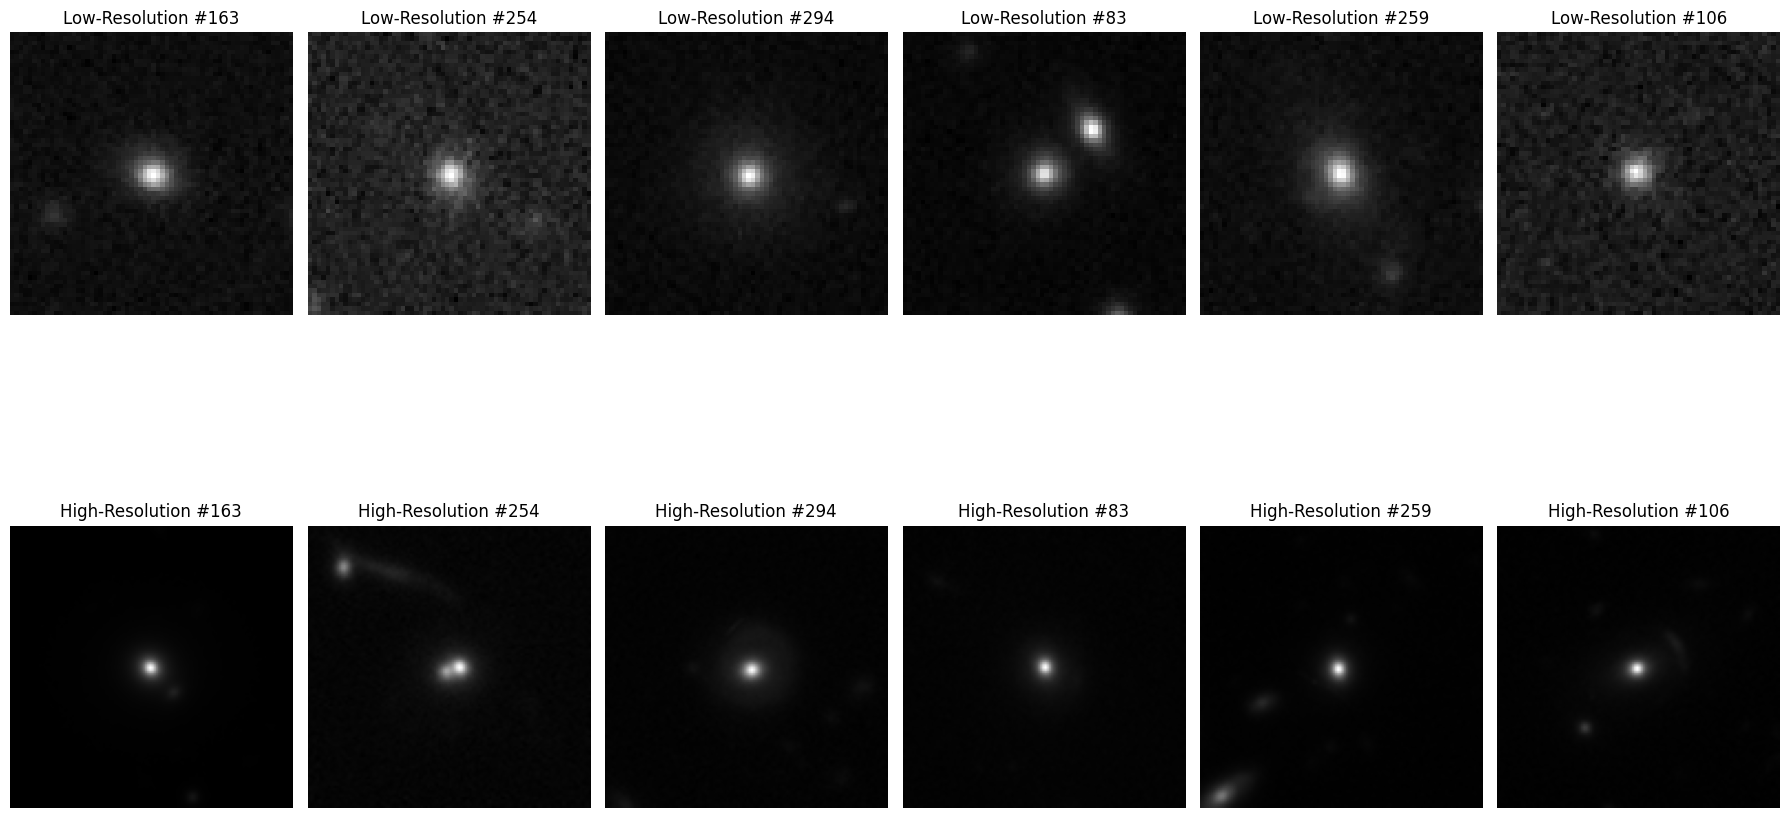

In [42]:
# Visualize sample images
def visualize_samples(hr_images, lr_images, n_samples=5):
    import matplotlib.pyplot as plt
    indices = np.random.choice(len(hr_images), n_samples, replace=False)
    fig, axes = plt.subplots(2, n_samples, figsize=(3*n_samples, 12))
    for i, idx in enumerate(indices):
        axes[0, i].imshow(lr_images[idx].squeeze(), cmap='gray')
        axes[0, i].set_title(f"Low-Resolution #{idx}")
        axes[0, i].axis('off')
        axes[1, i].imshow(hr_images[idx].squeeze(), cmap='gray')
        axes[1, i].set_title(f"High-Resolution #{idx}")
        axes[1, i].axis('off')
    plt.savefig("sample_image.png")    
    plt.tight_layout()
    plt.show()

visualize_samples(hr_images, lr_images, n_samples=6)


In [43]:
print(f"Total HR Images: {len(hr_images)}")
print(f"Total LR Images: {len(lr_images)}")


Total HR Images: 300
Total LR Images: 300


In [46]:
# Dataset Splitting
total_samples = len(hr_images)
train_size = int(0.90 * total_samples)
test_size = total_samples - train_size
indices = np.arange(total_samples)
np.random.shuffle(indices)
train_indices, test_indices = indices[:train_size], indices[train_size:]

num_augments = 10 
train_dataset = SuperresDataset(
    [hr_images[i] for i in train_indices], 
    [lr_images[i] for i in train_indices], 
    num_augments=num_augments
)

test_dataset = SuperresDataset(
    [hr_images[i] for i in test_indices], 
    [lr_images[i] for i in test_indices], 
    num_augments=1 
)

# DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset size
print(f"Original training samples: {train_size}")
print(f"Augmented training samples: {len(train_dataset)} (×{num_augments} increase)")
print(f"Original test samples: {test_size}")
print(f"Final test dataset size: {len(test_dataset)}")


Original training samples: 270
Augmented training samples: 2700 (×10 increase)
Original test samples: 30
Final test dataset size: 30


In [47]:
def check_for_nans(data_loader):
    for batch_idx, (lr, hr) in enumerate(data_loader):
        if torch.isnan(lr).any():
            print(f"NaN values found in LR images in batch {batch_idx}")
        if torch.isnan(hr).any():
            print(f"NaN values found in HR images in batch {batch_idx}")

check_for_nans(train_loader)

In [48]:
import torch
import numpy as np
import torch.nn.functional as F

def linear_beta_schedule(timesteps, beta_start=0.0001, beta_end=0.02):
    return torch.linspace(beta_start, beta_end, timesteps)

T = 1000
betas = linear_beta_schedule(T)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(hr, lr, t, device="cpu"):
    residual = hr - lr
    noise = torch.randn_like(residual)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, residual.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, residual.shape)
    
    noisy_residual = sqrt_alphas_cumprod_t.to(device) * residual.to(device) + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)
    
    return noisy_residual, noise.to(device)

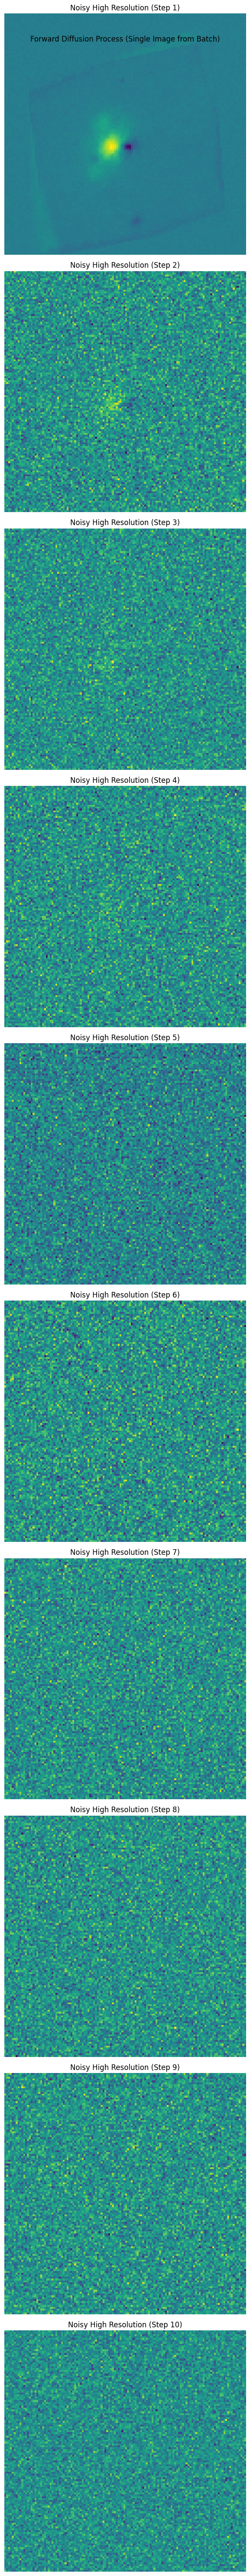

Forward diffusion process completed and visualized for a single image from the batch.


In [63]:
hr, lr = next(iter(train_loader))

image_index = 0 
steps = 10
fig, axs = plt.subplots(steps,1, figsize=(18, 6*steps))
fig.suptitle("Forward Diffusion Process (Single Image from Batch)")

for i in range(steps):
    t = torch.tensor([i * T // steps]).repeat(hr.size(0))
    noisy_residual, _ = forward_diffusion_sample(hr, lr, t)
    noisy_hr = noisy_residual
    lr_img = lr[image_index].squeeze().cpu().numpy()
    hr_img = hr[image_index].squeeze().cpu().numpy()
    noisy_hr_img = noisy_hr[image_index].squeeze().cpu().numpy()
    
    axs[i].imshow(noisy_hr_img, cmap='viridis')
    axs[i].set_title(f'Noisy High Resolution (Step {i+1})')
    axs[i].axis('off')

plt.tight_layout()
plt.savefig("forward_diffusion_process")
plt.show()

print("Forward diffusion process completed and visualized for a single image from the batch.")

In [50]:
import torch
from torch import nn
import math

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2 * in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        h = self.bnorm1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(...,) + (None,) * 2]
        h = h + time_emb
        h = self.bnorm2(self.relu(self.conv2(h)))
        return self.transform(h)

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class SimpleUnet(nn.Module):
    def __init__(self):
        super().__init__()
        image_channels = 2
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1
        time_emb_dim = 32
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i + 1], time_emb_dim) for i in range(len(down_channels) - 1)])
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i + 1], time_emb_dim, up=True) for i in range(len(up_channels) - 1)])
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        t = self.time_mlp(timestep)
        x = self.conv0(x)
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_model(model, train_loader, device, epochs=20, T=1000, lr=1e-5):
    
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    epoch_losses = []
    best_loss = float('inf')
    best_weights = None
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}", unit='batch') as pbar:
            for step, (lr_img, hr_img) in enumerate(train_loader):
                lr_img, hr_img = lr_img.to(device), hr_img.to(device)
                
                optimizer.zero_grad()
                
                timesteps = torch.randint(0, T, (lr_img.size(0),), device=device).long()
                noisy_residual, noise = forward_diffusion_sample(hr_img, lr_img, timesteps, device)
                
                model_input = torch.cat([lr_img, noisy_residual], dim=1)
                
                predicted_residual = model(model_input, timesteps)
                predicted_hr = lr_img + predicted_residual
                
                loss = nn.L1Loss()(predicted_hr, hr_img)
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
                pbar.set_postfix({'loss': loss.item()})
                pbar.update(1)
        
        avg_epoch_loss = epoch_loss / len(train_loader)
        epoch_losses.append(avg_epoch_loss)
        print(f"End of Epoch {epoch+1} | Avg Loss: {avg_epoch_loss:.8f}")
        if avg_epoch_loss < best_loss:
            best_loss = avg_epoch_loss
            best_weights = model.state_dict()
            print(f"New best loss: {best_loss:.8f}")
    model.load_state_dict(best_weights)
    print("Training complete.")
    return epoch_losses



In [59]:
losses = train_model(model, train_loader, device, epochs=50, lr=1e-6)

Epoch 1/50: 100%|██████████| 85/85 [00:50<00:00,  1.67batch/s, loss=0.0466]


End of Epoch 1 | Avg Loss: 0.01781664
New best loss: 0.01781664


Epoch 2/50: 100%|██████████| 85/85 [00:50<00:00,  1.67batch/s, loss=0.0164]


End of Epoch 2 | Avg Loss: 0.01694702
New best loss: 0.01694702


Epoch 3/50: 100%|██████████| 85/85 [00:51<00:00,  1.66batch/s, loss=0.0129]


End of Epoch 3 | Avg Loss: 0.01668513
New best loss: 0.01668513


Epoch 4/50: 100%|██████████| 85/85 [00:50<00:00,  1.67batch/s, loss=0.00846]


End of Epoch 4 | Avg Loss: 0.01743237


Epoch 5/50: 100%|██████████| 85/85 [00:51<00:00,  1.67batch/s, loss=0.0189]


End of Epoch 5 | Avg Loss: 0.01692263


Epoch 6/50: 100%|██████████| 85/85 [00:51<00:00,  1.67batch/s, loss=0.0243]


End of Epoch 6 | Avg Loss: 0.01781729


Epoch 7/50: 100%|██████████| 85/85 [00:50<00:00,  1.67batch/s, loss=0.0133]


End of Epoch 7 | Avg Loss: 0.01674272


Epoch 8/50: 100%|██████████| 85/85 [00:50<00:00,  1.67batch/s, loss=0.0379] 


End of Epoch 8 | Avg Loss: 0.01693620


Epoch 9/50: 100%|██████████| 85/85 [00:50<00:00,  1.67batch/s, loss=0.0538] 


End of Epoch 9 | Avg Loss: 0.01728903


Epoch 10/50: 100%|██████████| 85/85 [00:50<00:00,  1.67batch/s, loss=0.0192] 


End of Epoch 10 | Avg Loss: 0.01707601


Epoch 11/50: 100%|██████████| 85/85 [00:50<00:00,  1.67batch/s, loss=0.0169] 


End of Epoch 11 | Avg Loss: 0.01649407
New best loss: 0.01649407


Epoch 12/50: 100%|██████████| 85/85 [00:50<00:00,  1.67batch/s, loss=0.018] 


End of Epoch 12 | Avg Loss: 0.01651653


Epoch 13/50: 100%|██████████| 85/85 [00:51<00:00,  1.66batch/s, loss=0.0277]


End of Epoch 13 | Avg Loss: 0.01650505


Epoch 14/50: 100%|██████████| 85/85 [00:51<00:00,  1.66batch/s, loss=0.0173]


End of Epoch 14 | Avg Loss: 0.01728999


Epoch 15/50: 100%|██████████| 85/85 [00:50<00:00,  1.67batch/s, loss=0.0199]


End of Epoch 15 | Avg Loss: 0.01616176
New best loss: 0.01616176


Epoch 16/50: 100%|██████████| 85/85 [00:51<00:00,  1.66batch/s, loss=0.0138]


End of Epoch 16 | Avg Loss: 0.01670234


Epoch 17/50: 100%|██████████| 85/85 [00:51<00:00,  1.66batch/s, loss=0.0197]


End of Epoch 17 | Avg Loss: 0.01648516


Epoch 18/50: 100%|██████████| 85/85 [00:50<00:00,  1.67batch/s, loss=0.0134]


End of Epoch 18 | Avg Loss: 0.01695031


Epoch 19/50: 100%|██████████| 85/85 [00:51<00:00,  1.66batch/s, loss=0.02]  


End of Epoch 19 | Avg Loss: 0.01730459


Epoch 20/50: 100%|██████████| 85/85 [00:50<00:00,  1.67batch/s, loss=0.0114]


End of Epoch 20 | Avg Loss: 0.01639167


Epoch 21/50: 100%|██████████| 85/85 [00:50<00:00,  1.67batch/s, loss=0.0184]


End of Epoch 21 | Avg Loss: 0.01686528


Epoch 22/50: 100%|██████████| 85/85 [00:51<00:00,  1.66batch/s, loss=0.0182] 


End of Epoch 22 | Avg Loss: 0.01695807


Epoch 23/50: 100%|██████████| 85/85 [00:51<00:00,  1.67batch/s, loss=0.0151] 


End of Epoch 23 | Avg Loss: 0.01675284


Epoch 24/50: 100%|██████████| 85/85 [00:51<00:00,  1.66batch/s, loss=0.024] 


End of Epoch 24 | Avg Loss: 0.01666790


Epoch 25/50: 100%|██████████| 85/85 [00:51<00:00,  1.67batch/s, loss=0.0179] 


End of Epoch 25 | Avg Loss: 0.01670316


Epoch 26/50: 100%|██████████| 85/85 [00:51<00:00,  1.66batch/s, loss=0.00855]


End of Epoch 26 | Avg Loss: 0.01695303


Epoch 27/50: 100%|██████████| 85/85 [00:50<00:00,  1.67batch/s, loss=0.0652] 


End of Epoch 27 | Avg Loss: 0.01699132


Epoch 28/50: 100%|██████████| 85/85 [00:51<00:00,  1.66batch/s, loss=0.0334] 


End of Epoch 28 | Avg Loss: 0.01660960


Epoch 29/50: 100%|██████████| 85/85 [00:51<00:00,  1.66batch/s, loss=0.0232] 


End of Epoch 29 | Avg Loss: 0.01651142


Epoch 30/50: 100%|██████████| 85/85 [00:50<00:00,  1.67batch/s, loss=0.0266]


End of Epoch 30 | Avg Loss: 0.01640329


Epoch 31/50: 100%|██████████| 85/85 [00:51<00:00,  1.66batch/s, loss=0.0247]


End of Epoch 31 | Avg Loss: 0.01636459


Epoch 32/50: 100%|██████████| 85/85 [00:50<00:00,  1.68batch/s, loss=0.0294]


End of Epoch 32 | Avg Loss: 0.01658790


Epoch 33/50: 100%|██████████| 85/85 [00:50<00:00,  1.67batch/s, loss=0.02]  


End of Epoch 33 | Avg Loss: 0.01691217


Epoch 34/50: 100%|██████████| 85/85 [00:50<00:00,  1.67batch/s, loss=0.0352]


End of Epoch 34 | Avg Loss: 0.01697928


Epoch 35/50: 100%|██████████| 85/85 [00:50<00:00,  1.67batch/s, loss=0.0173]


End of Epoch 35 | Avg Loss: 0.01669833


Epoch 36/50: 100%|██████████| 85/85 [00:51<00:00,  1.64batch/s, loss=0.0184]


End of Epoch 36 | Avg Loss: 0.01722726


Epoch 37/50: 100%|██████████| 85/85 [00:51<00:00,  1.64batch/s, loss=0.0117] 


End of Epoch 37 | Avg Loss: 0.01689663


Epoch 38/50: 100%|██████████| 85/85 [00:51<00:00,  1.65batch/s, loss=0.0107]


End of Epoch 38 | Avg Loss: 0.01697357


Epoch 39/50: 100%|██████████| 85/85 [00:51<00:00,  1.66batch/s, loss=0.0309]


End of Epoch 39 | Avg Loss: 0.01580638
New best loss: 0.01580638


Epoch 40/50: 100%|██████████| 85/85 [00:51<00:00,  1.67batch/s, loss=0.0157] 


End of Epoch 40 | Avg Loss: 0.01676538


Epoch 41/50: 100%|██████████| 85/85 [00:50<00:00,  1.67batch/s, loss=0.0155] 


End of Epoch 41 | Avg Loss: 0.01652489


Epoch 42/50: 100%|██████████| 85/85 [00:50<00:00,  1.67batch/s, loss=0.0175] 


End of Epoch 42 | Avg Loss: 0.01627738


Epoch 43/50: 100%|██████████| 85/85 [00:50<00:00,  1.67batch/s, loss=0.0223]


End of Epoch 43 | Avg Loss: 0.01704059


Epoch 44/50: 100%|██████████| 85/85 [00:50<00:00,  1.67batch/s, loss=0.012] 


End of Epoch 44 | Avg Loss: 0.01748142


Epoch 45/50: 100%|██████████| 85/85 [00:51<00:00,  1.67batch/s, loss=0.0153]


End of Epoch 45 | Avg Loss: 0.01611947


Epoch 46/50: 100%|██████████| 85/85 [00:51<00:00,  1.66batch/s, loss=0.024] 


End of Epoch 46 | Avg Loss: 0.01592283


Epoch 47/50: 100%|██████████| 85/85 [00:51<00:00,  1.67batch/s, loss=0.0163]


End of Epoch 47 | Avg Loss: 0.01711902


Epoch 48/50: 100%|██████████| 85/85 [00:50<00:00,  1.67batch/s, loss=0.0178] 


End of Epoch 48 | Avg Loss: 0.01632404


Epoch 49/50: 100%|██████████| 85/85 [00:50<00:00,  1.67batch/s, loss=0.0212] 


End of Epoch 49 | Avg Loss: 0.01700992


Epoch 50/50: 100%|██████████| 85/85 [00:50<00:00,  1.67batch/s, loss=0.0184]

End of Epoch 50 | Avg Loss: 0.01643819
Training complete.


In [60]:
torch.save(model.state_dict(), '/kaggle/working/try_2.pth') 

In [61]:
import torch
import numpy as np
from torch import nn
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm import tqdm

def calculate_psnr(img1, img2):
    mse = nn.functional.mse_loss(img1, img2)
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

def calculate_ssim(img1, img2, data_range=1.0, win_size=11):
    img1 = img1.squeeze().cpu().numpy()
    img2 = img2.squeeze().cpu().numpy()
    return structural_similarity(img1, img2, win_size=win_size, data_range=data_range, multichannel=False)

def evaluate_model(model, dataloader, device, win_size=11, data_range=1.0):
    model.eval()
    mse_hr_predhr = 0.0
    psnr_hr_predhr = 0.0
    ssim_hr_predhr = 0.0
    num_samples = 0
    
    with torch.no_grad():
        for lr_batch, hr_batch in tqdm(dataloader, desc="Evaluating"):
            lr_batch, hr_batch = lr_batch.to(device), hr_batch.to(device)
            batch_size = lr_batch.size(0)
            
            for i in range(batch_size):
                lr, hr = lr_batch[i].unsqueeze(0), hr_batch[i].unsqueeze(0)
                random_residual = torch.randn_like(lr)
                model_input = torch.cat([lr, random_residual], dim=1)
                timesteps = torch.tensor([1000], device=device).long()
                
                predicted_residual = model(model_input, timesteps)
                predicted_hr = lr + predicted_residual
                
                mse_hr_predhr += nn.MSELoss()(hr, predicted_hr).item()
                psnr_hr_predhr += calculate_psnr(hr, predicted_hr).item()
                ssim_hr_predhr += calculate_ssim(hr, predicted_hr, data_range, win_size)
                
                num_samples += 1
    
    mse_hr_predhr /= num_samples
    psnr_hr_predhr /= num_samples
    ssim_hr_predhr /= num_samples
    
    print(f"Avg MSE (HR, Predicted HR): {mse_hr_predhr:.8f}")
    print(f"Avg PSNR (HR, Predicted HR): {psnr_hr_predhr:.8f}")
    print(f"Avg SSIM (HR, Predicted HR): {ssim_hr_predhr:.8f}")

evaluate_model(model, test_loader, device)

Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

Avg MSE (HR, Predicted HR): 0.00190619
Avg PSNR (HR, Predicted HR): 28.75791976
Avg SSIM (HR, Predicted HR): 0.68899942


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

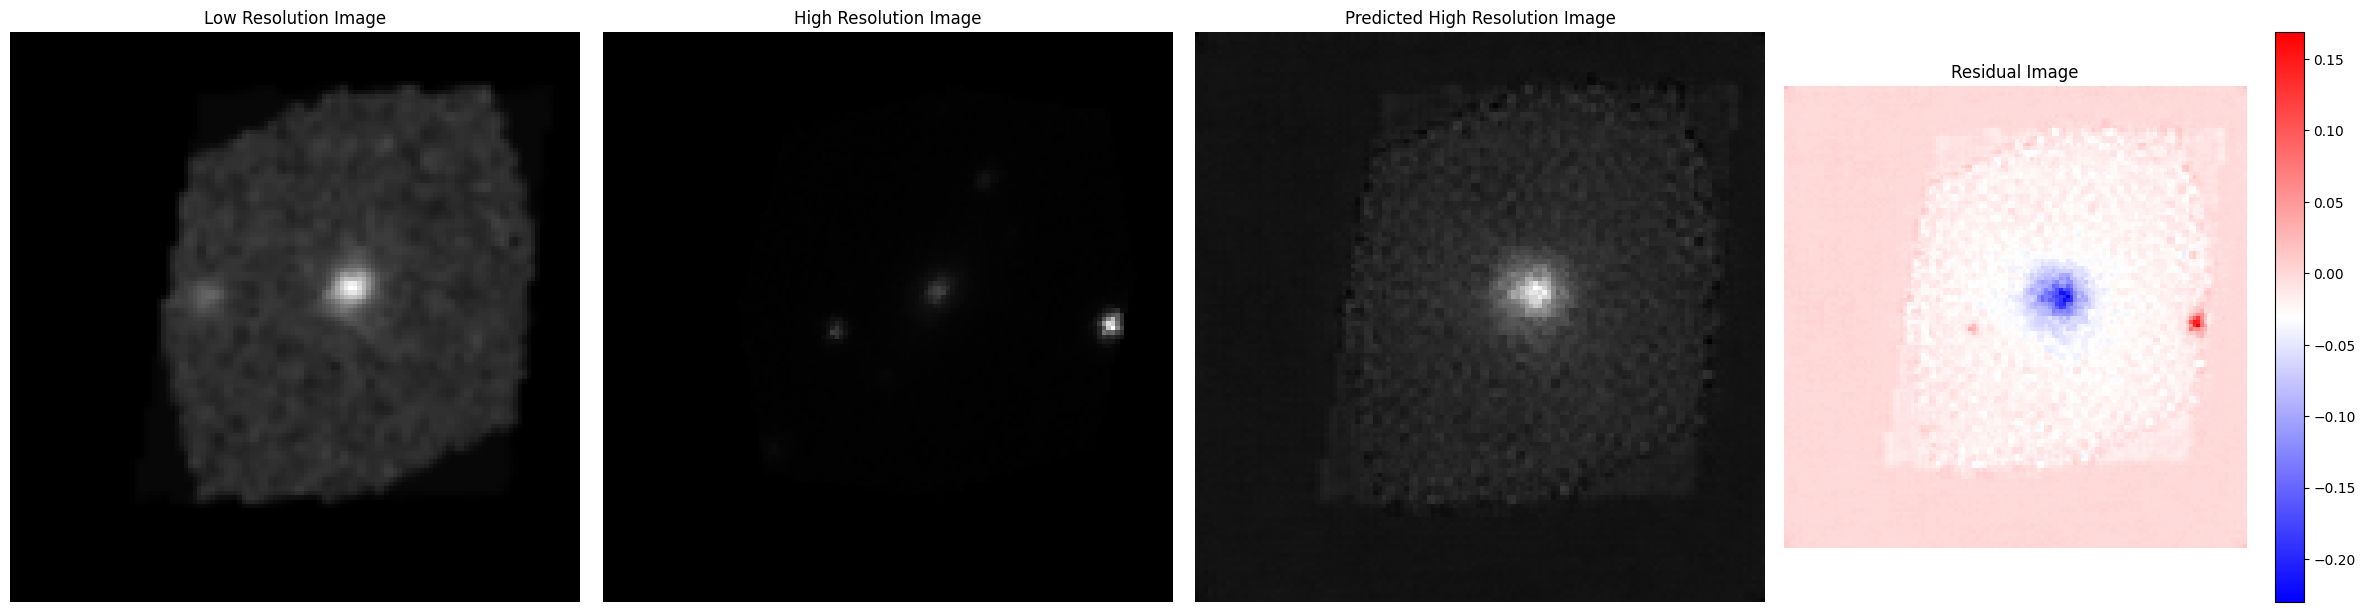

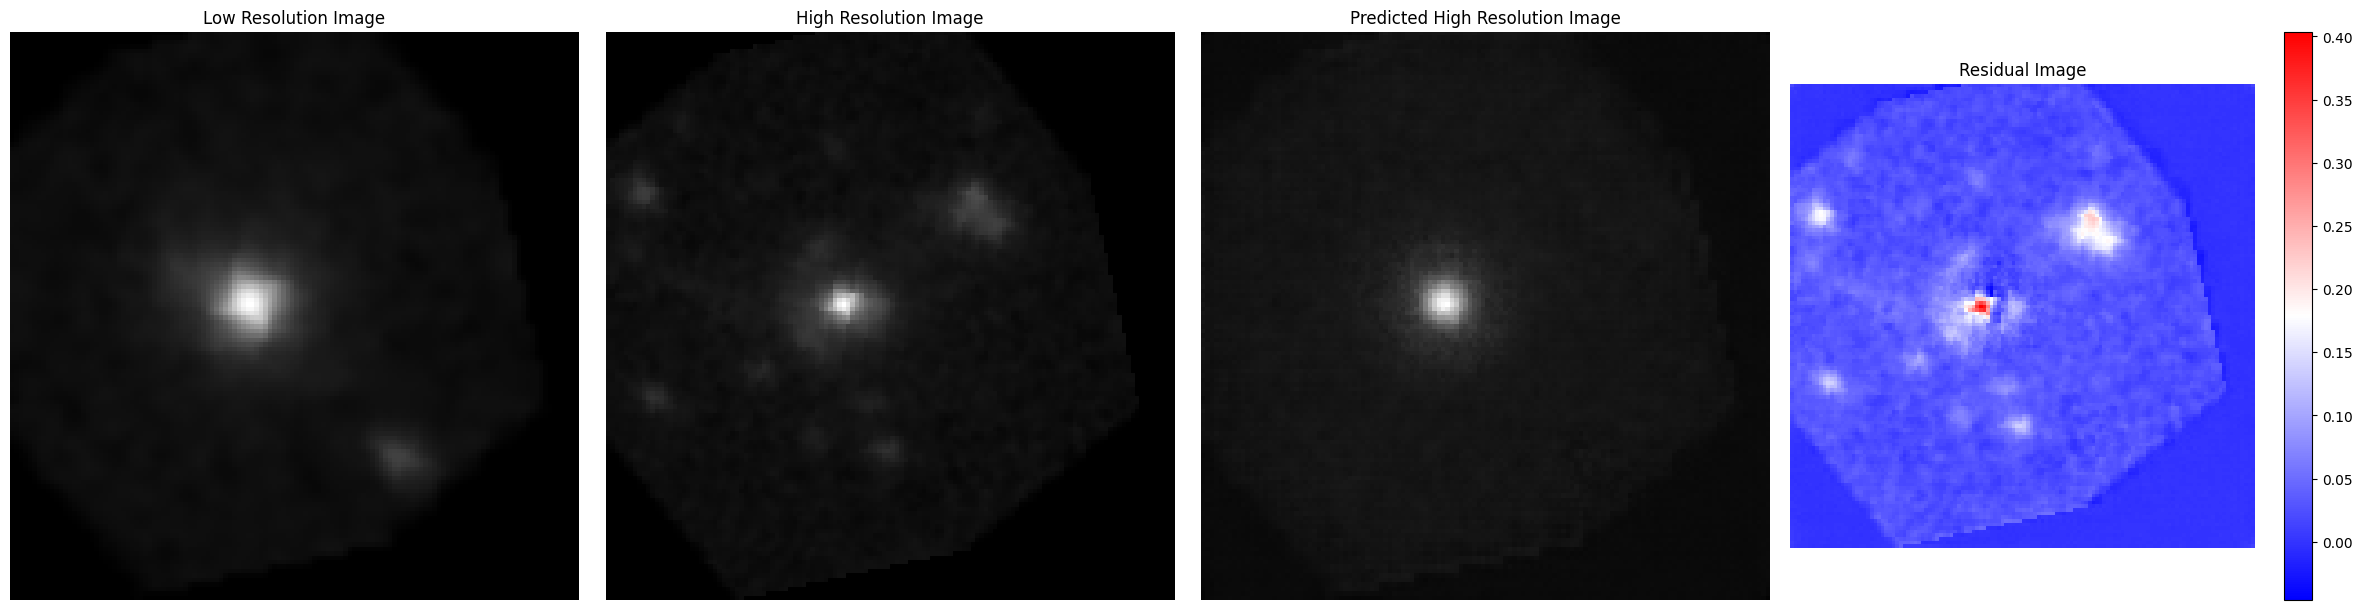

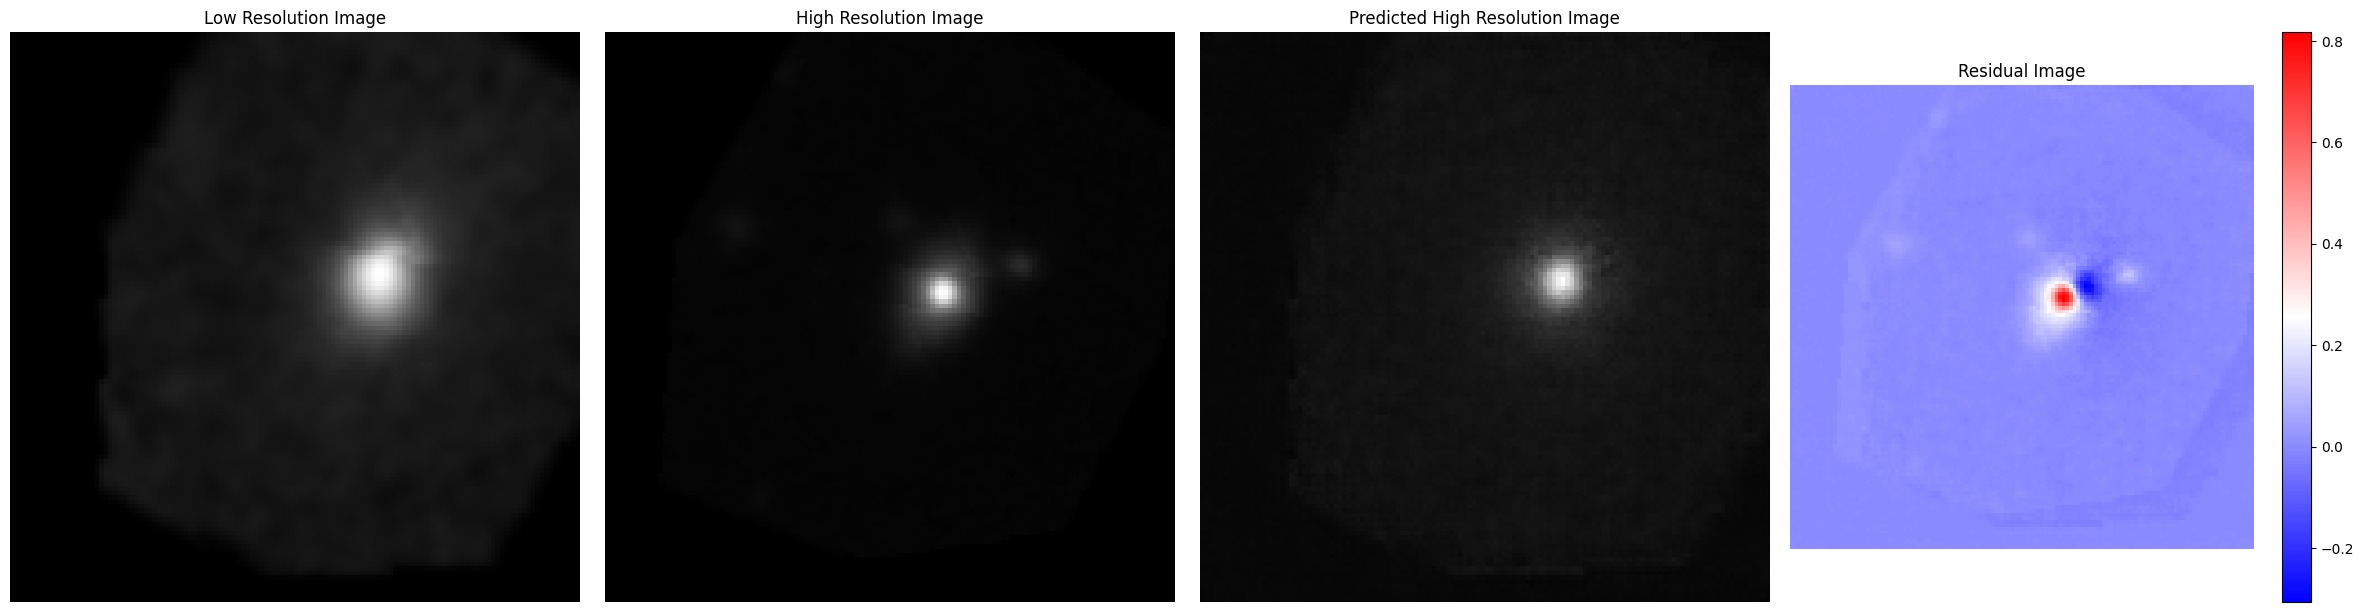

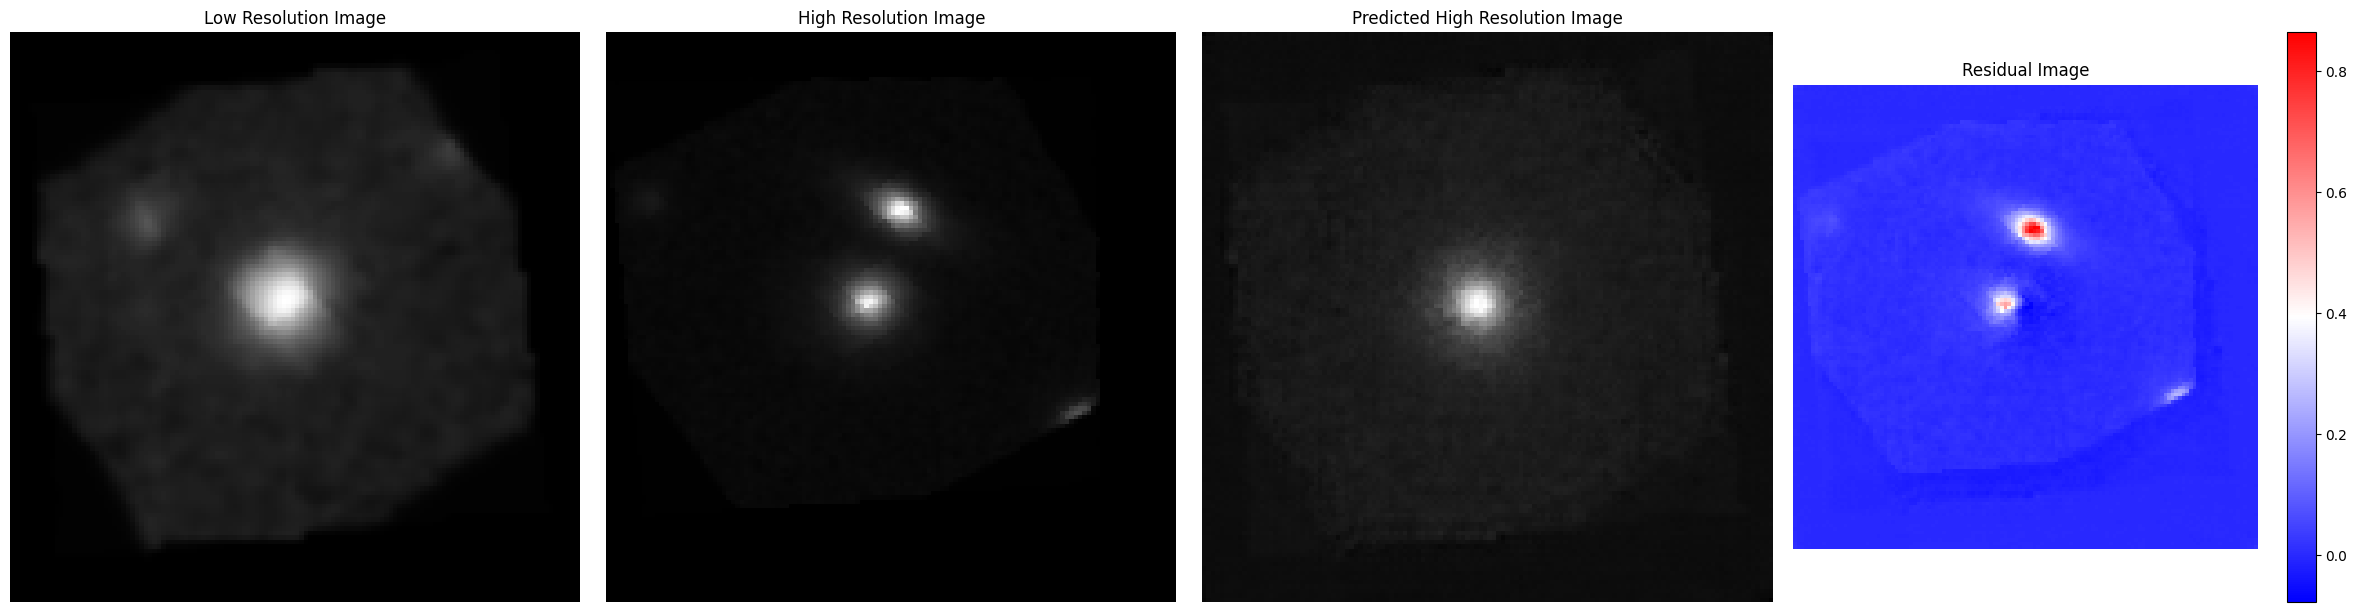

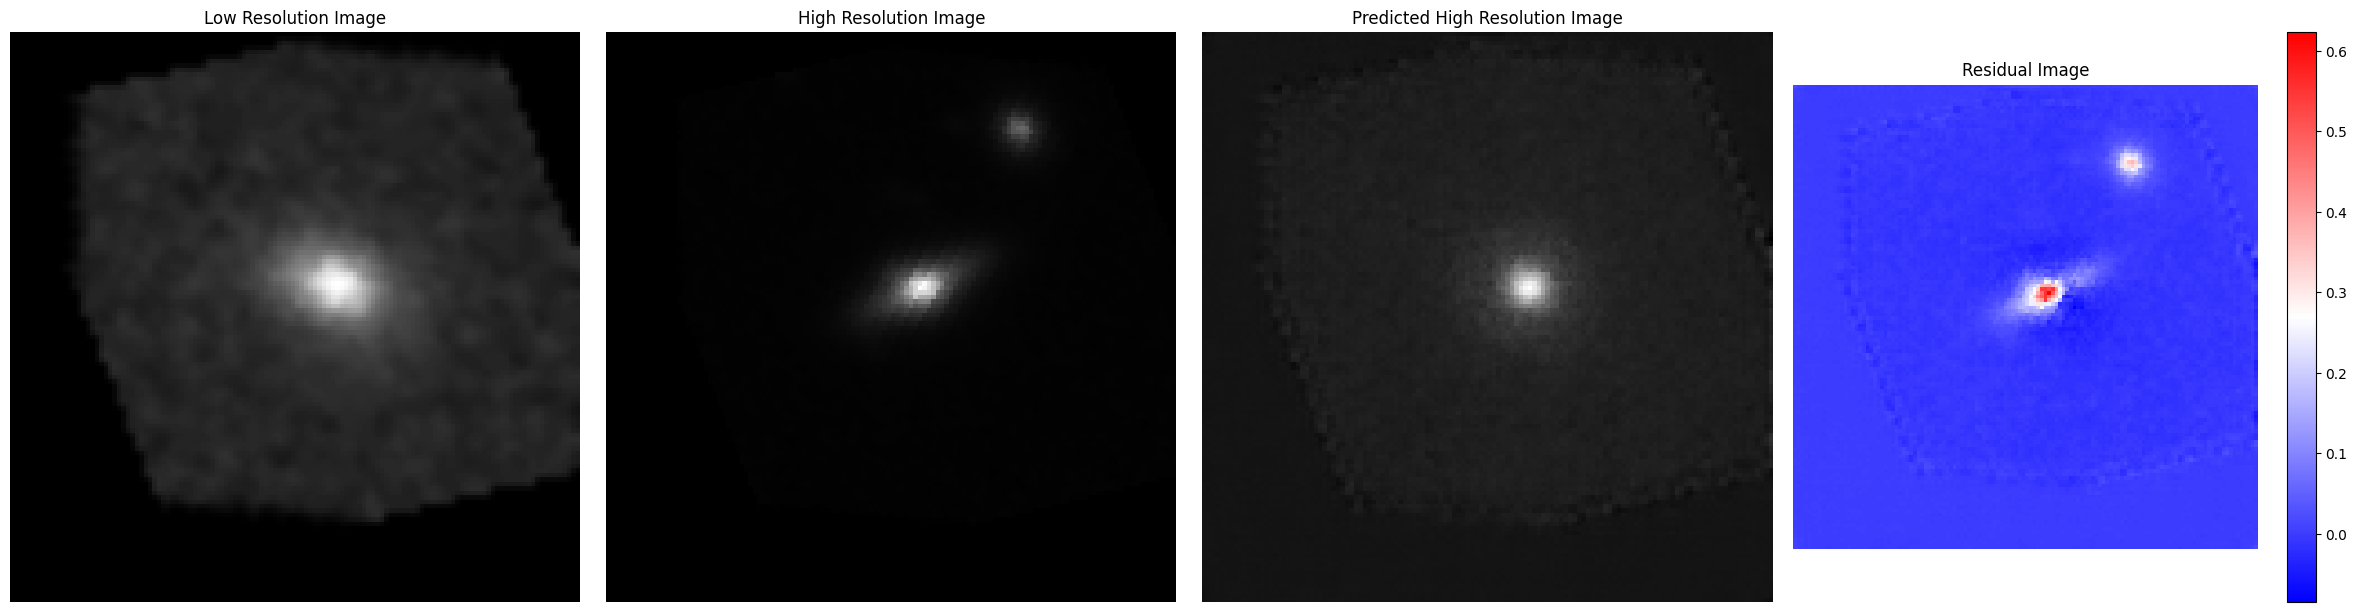

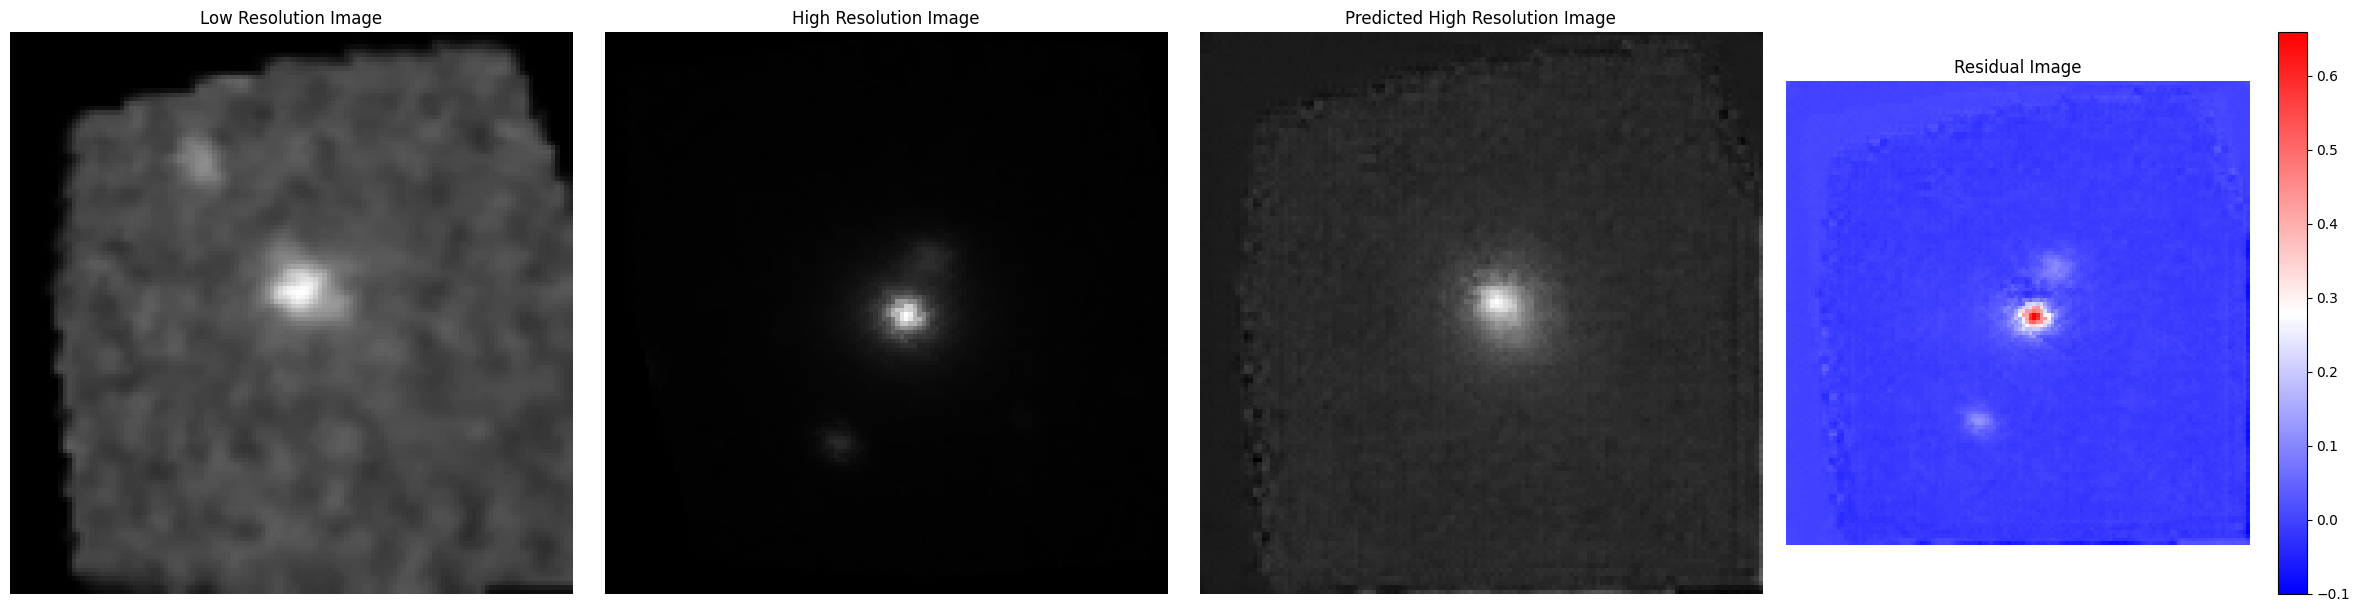

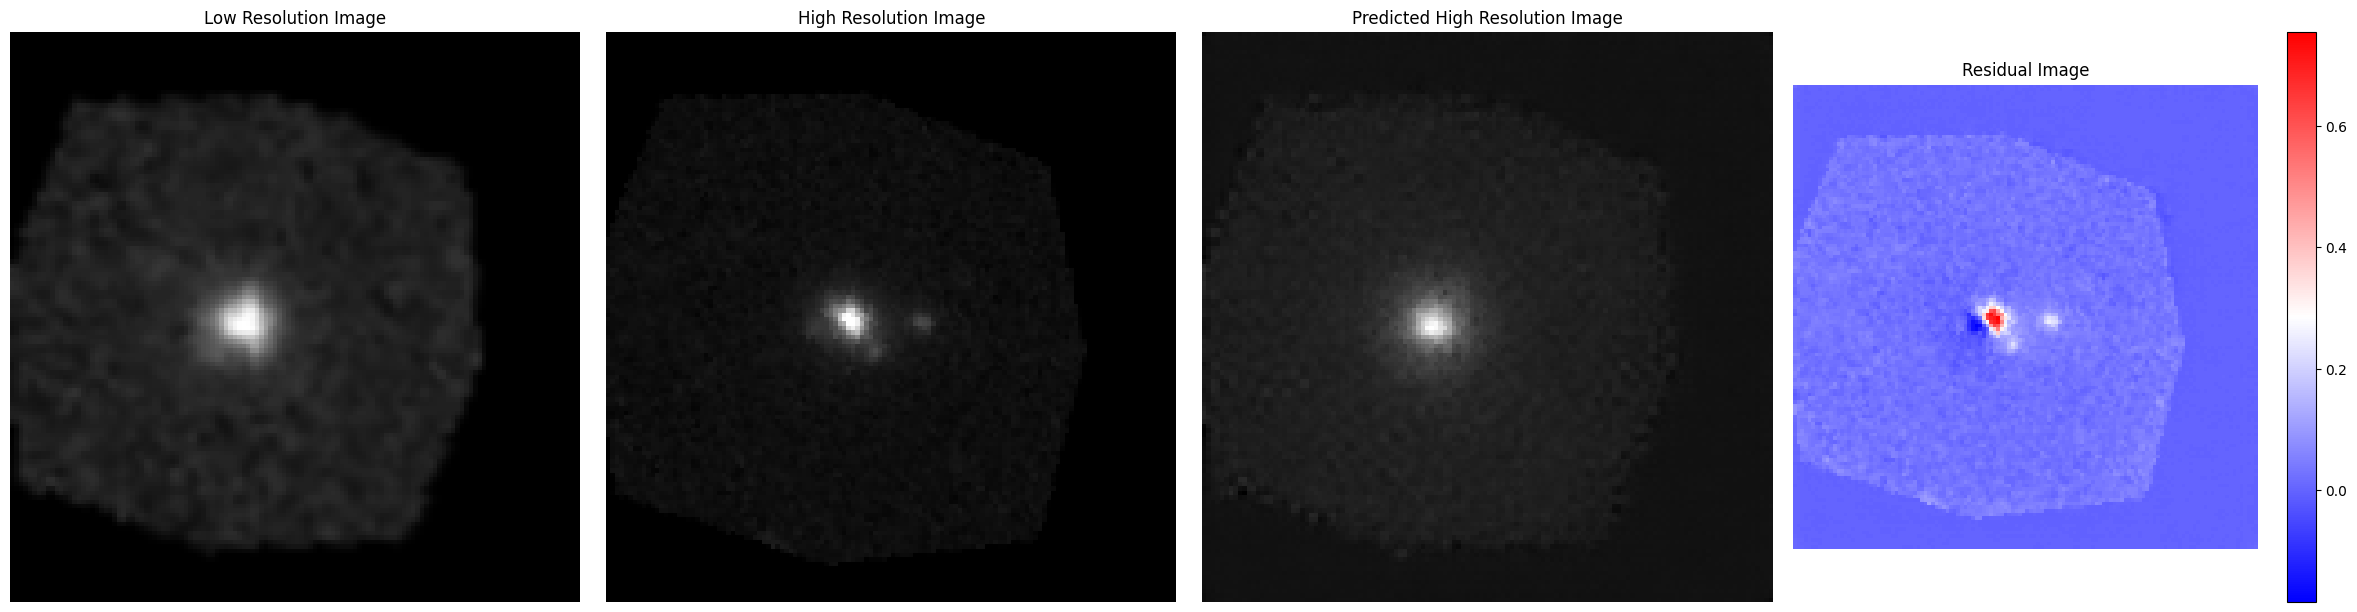

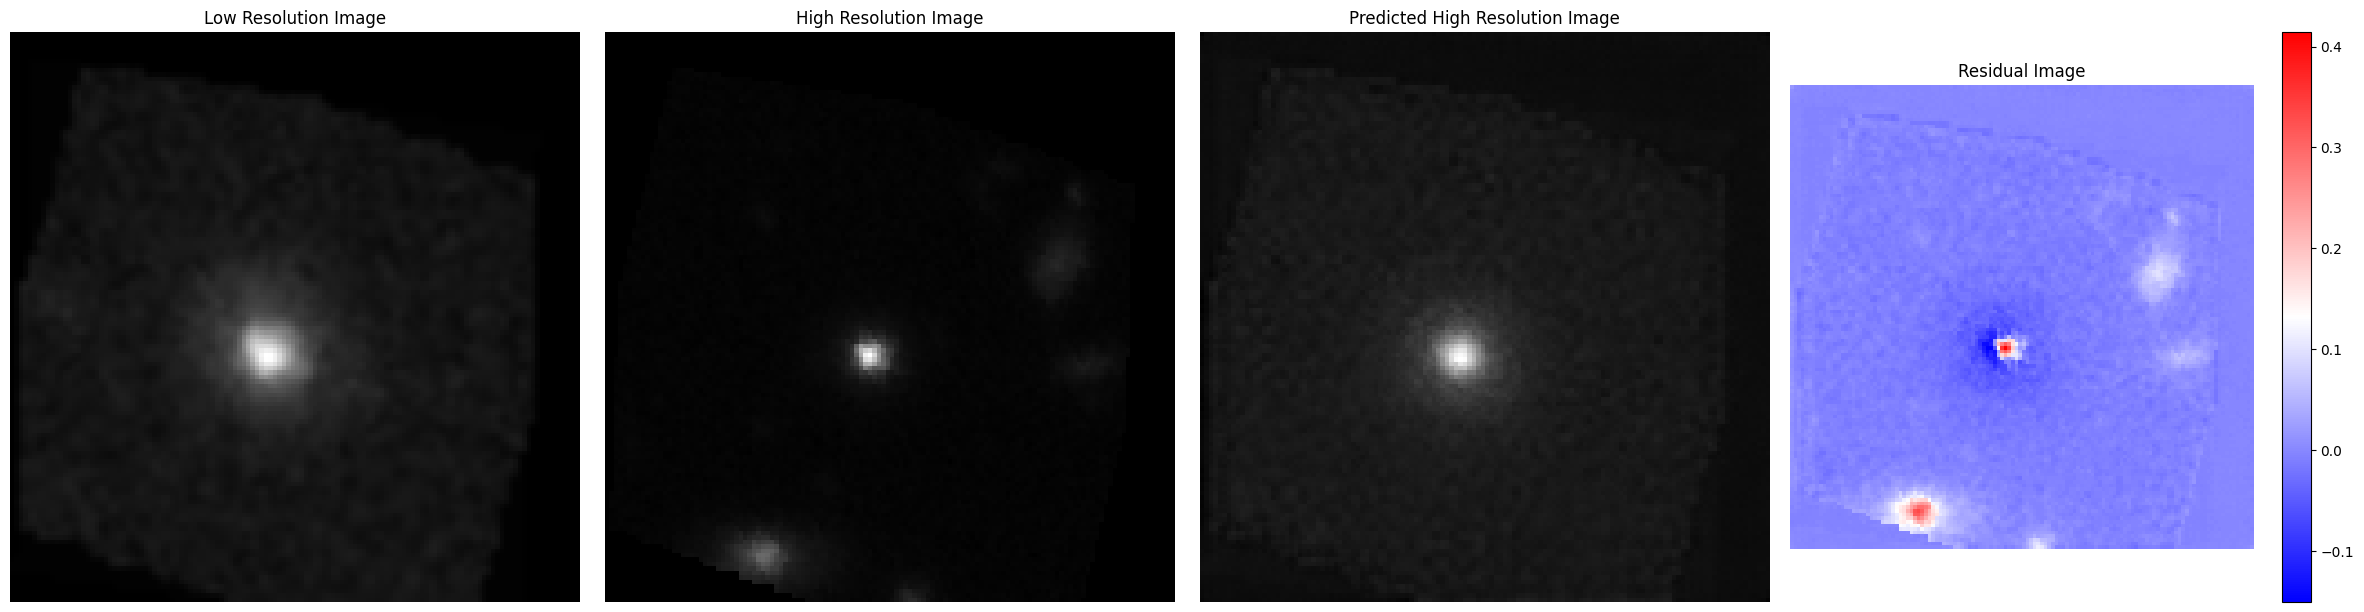

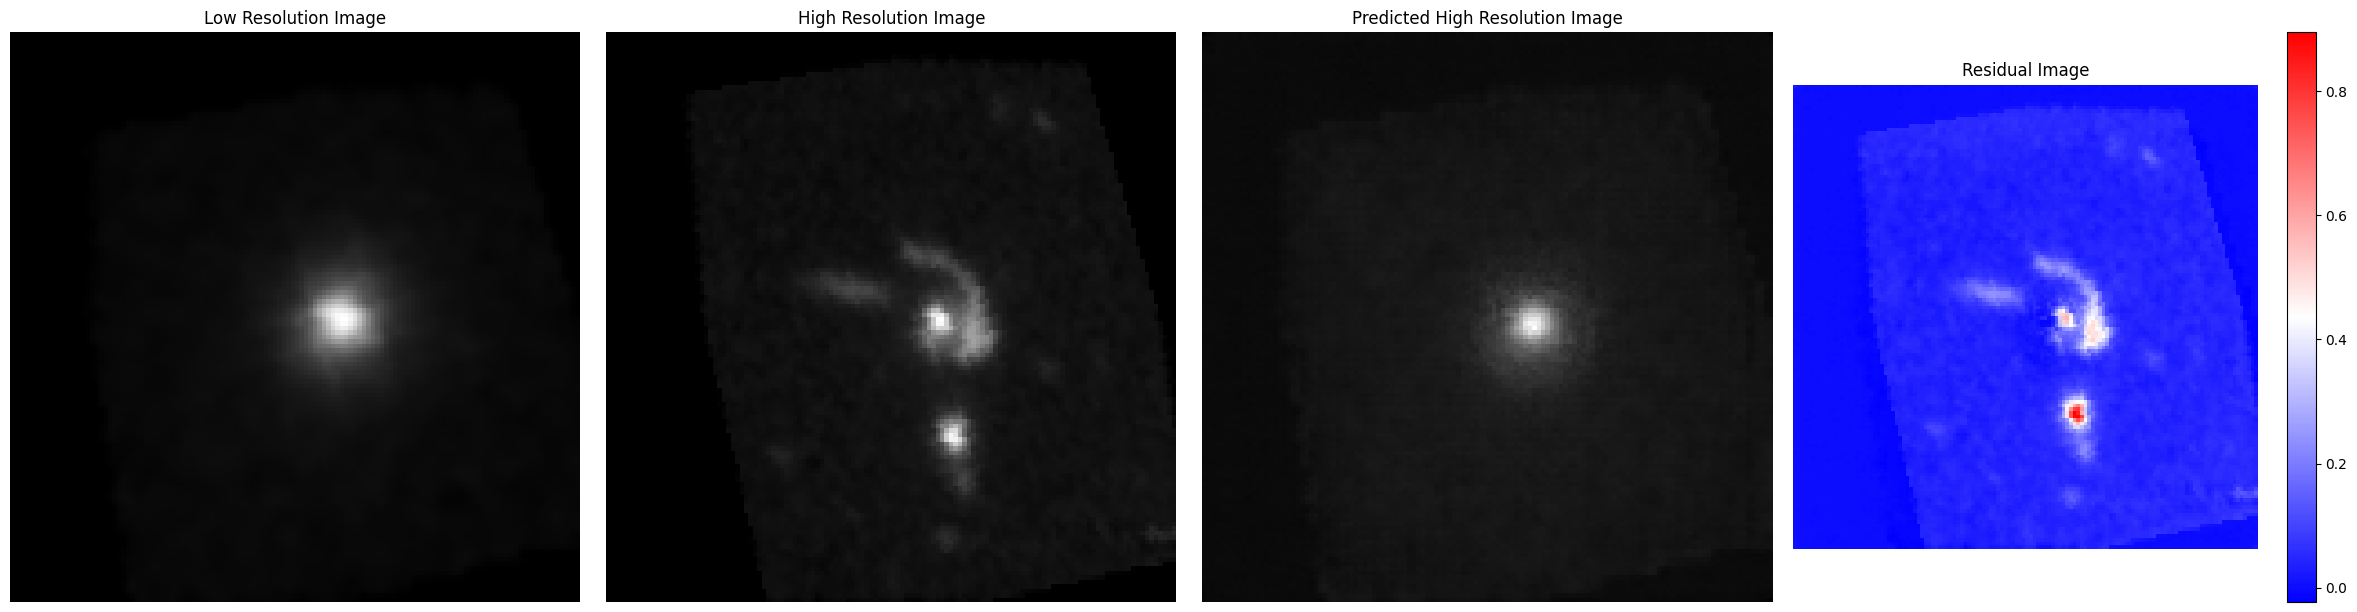

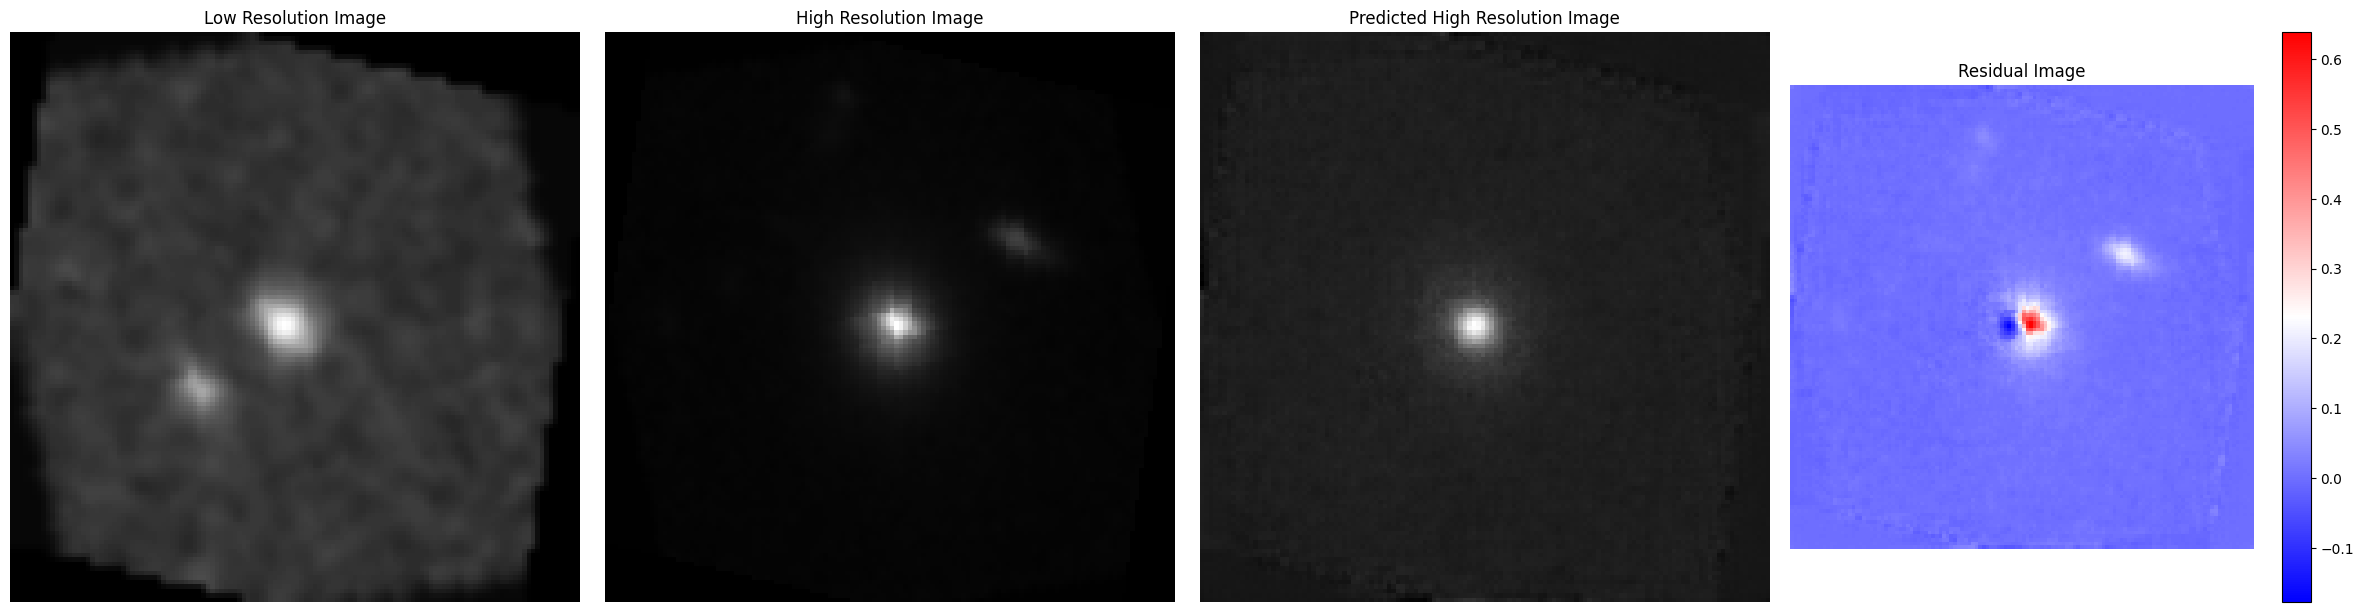

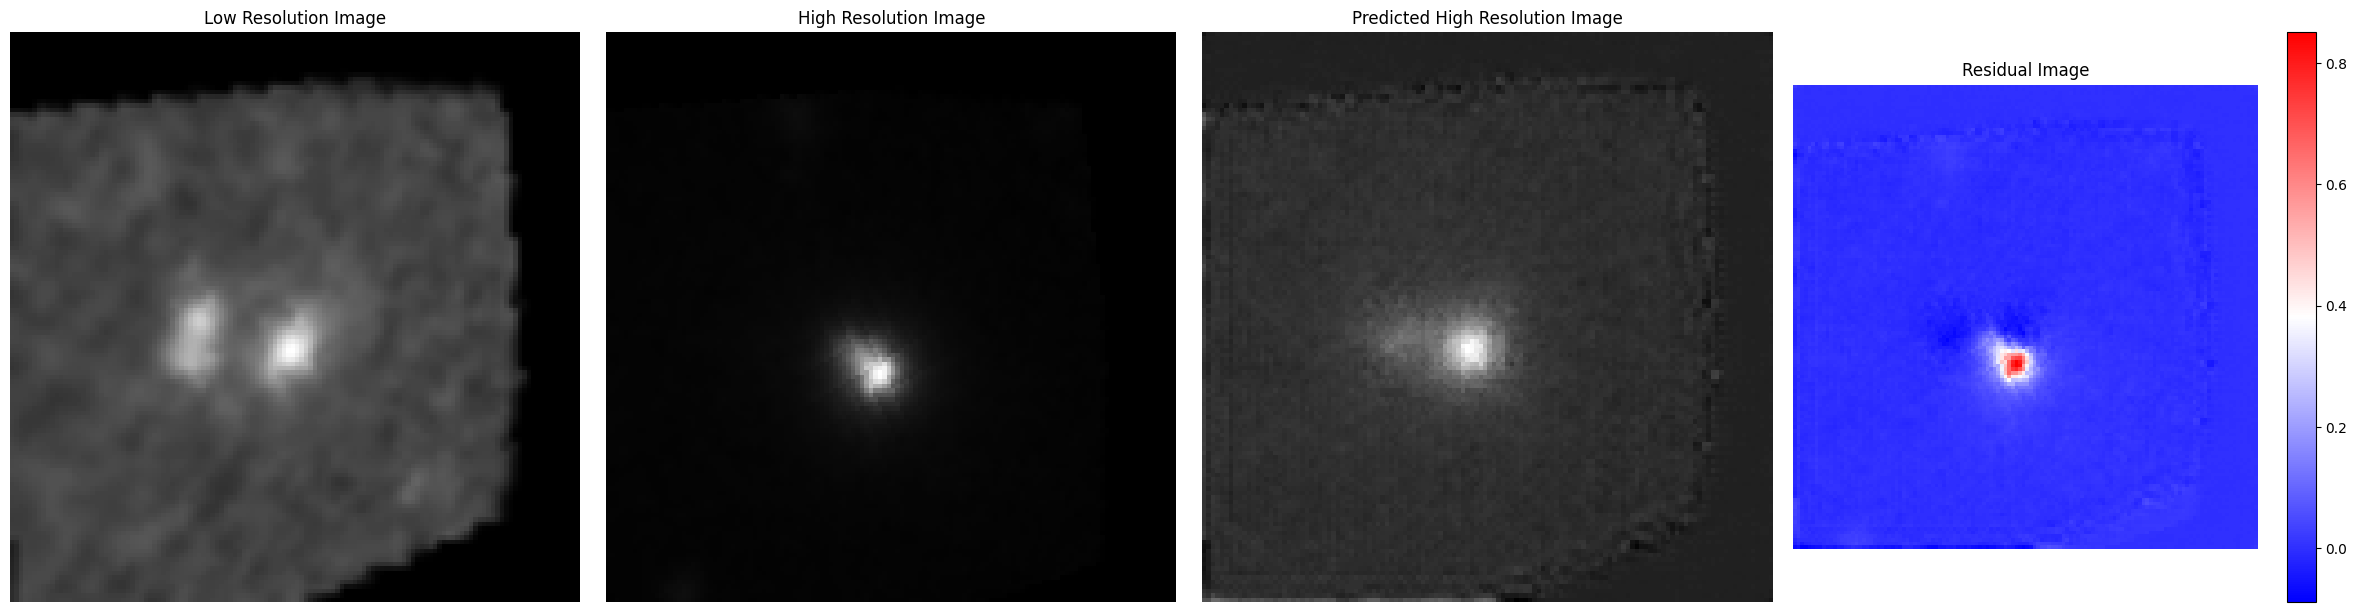

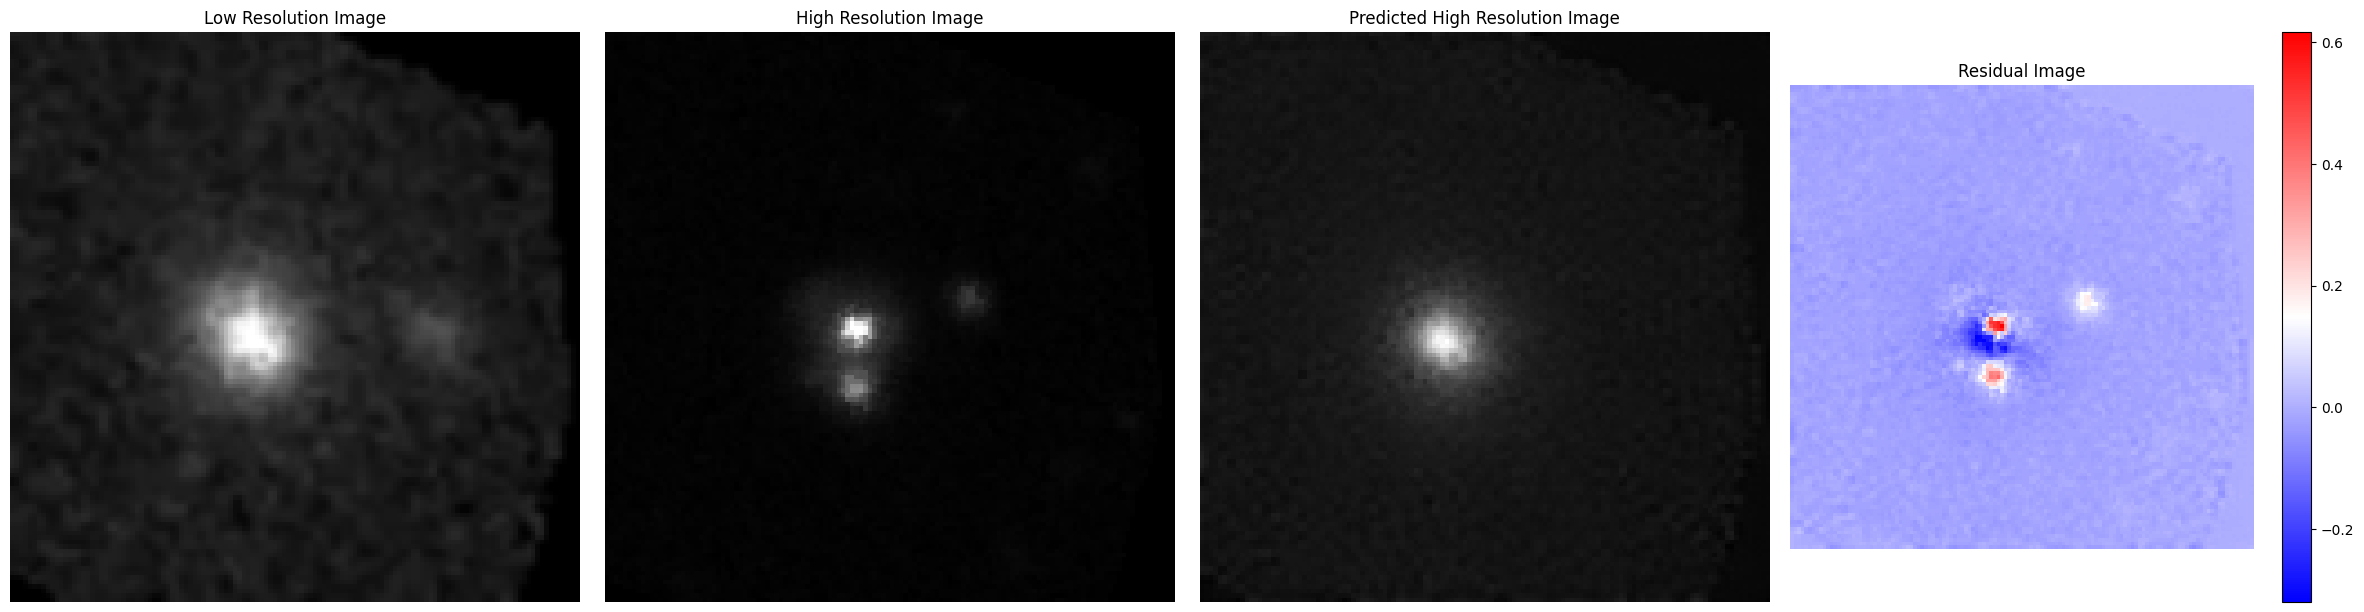

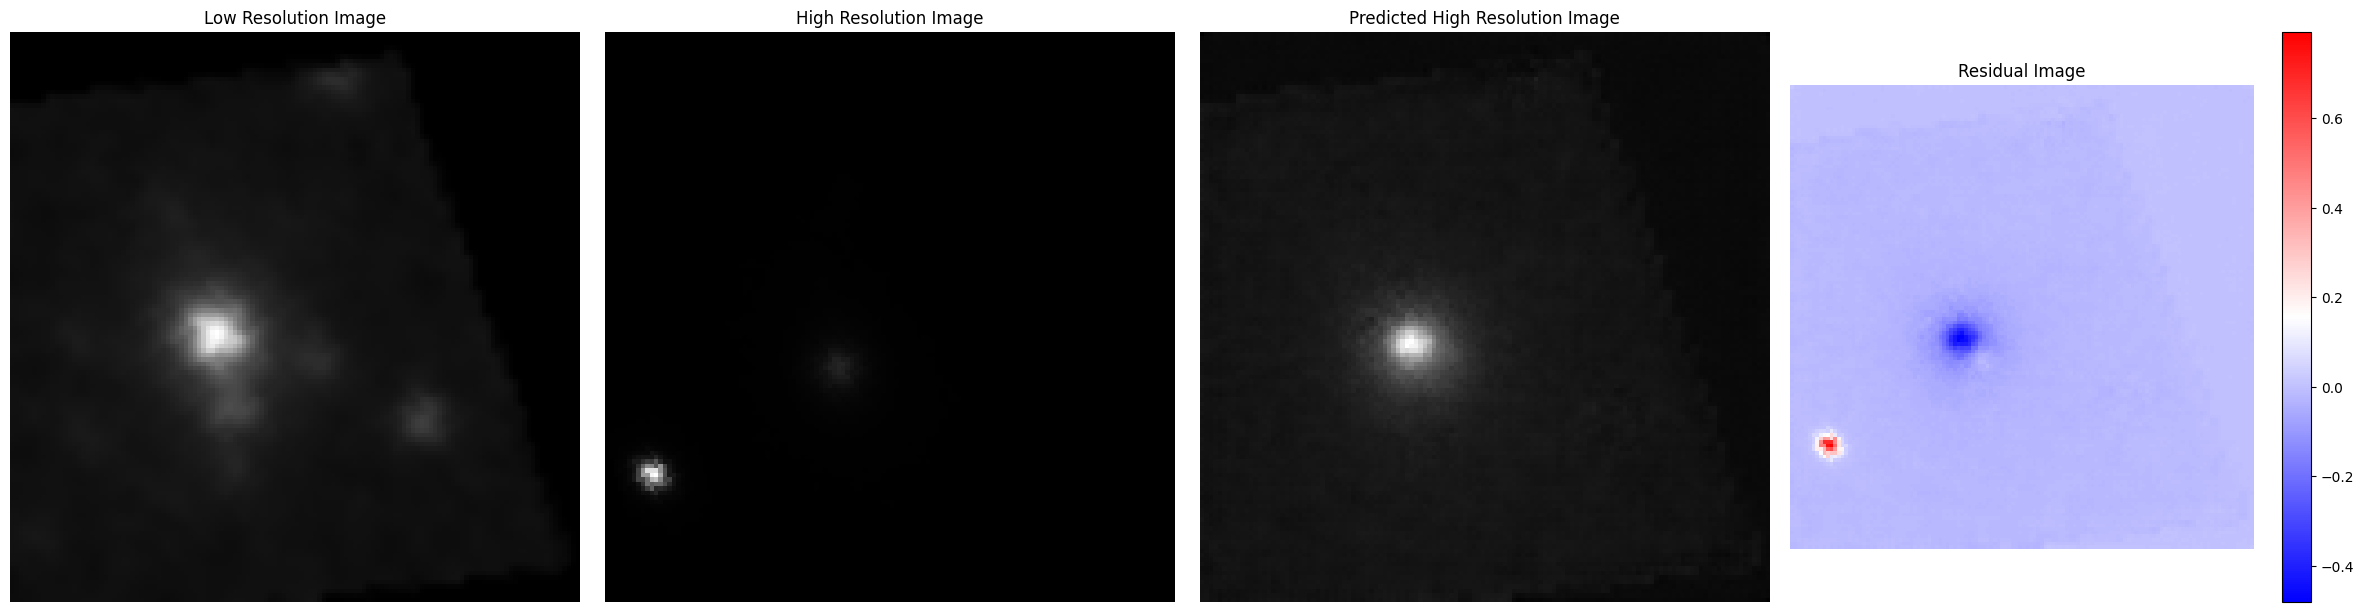

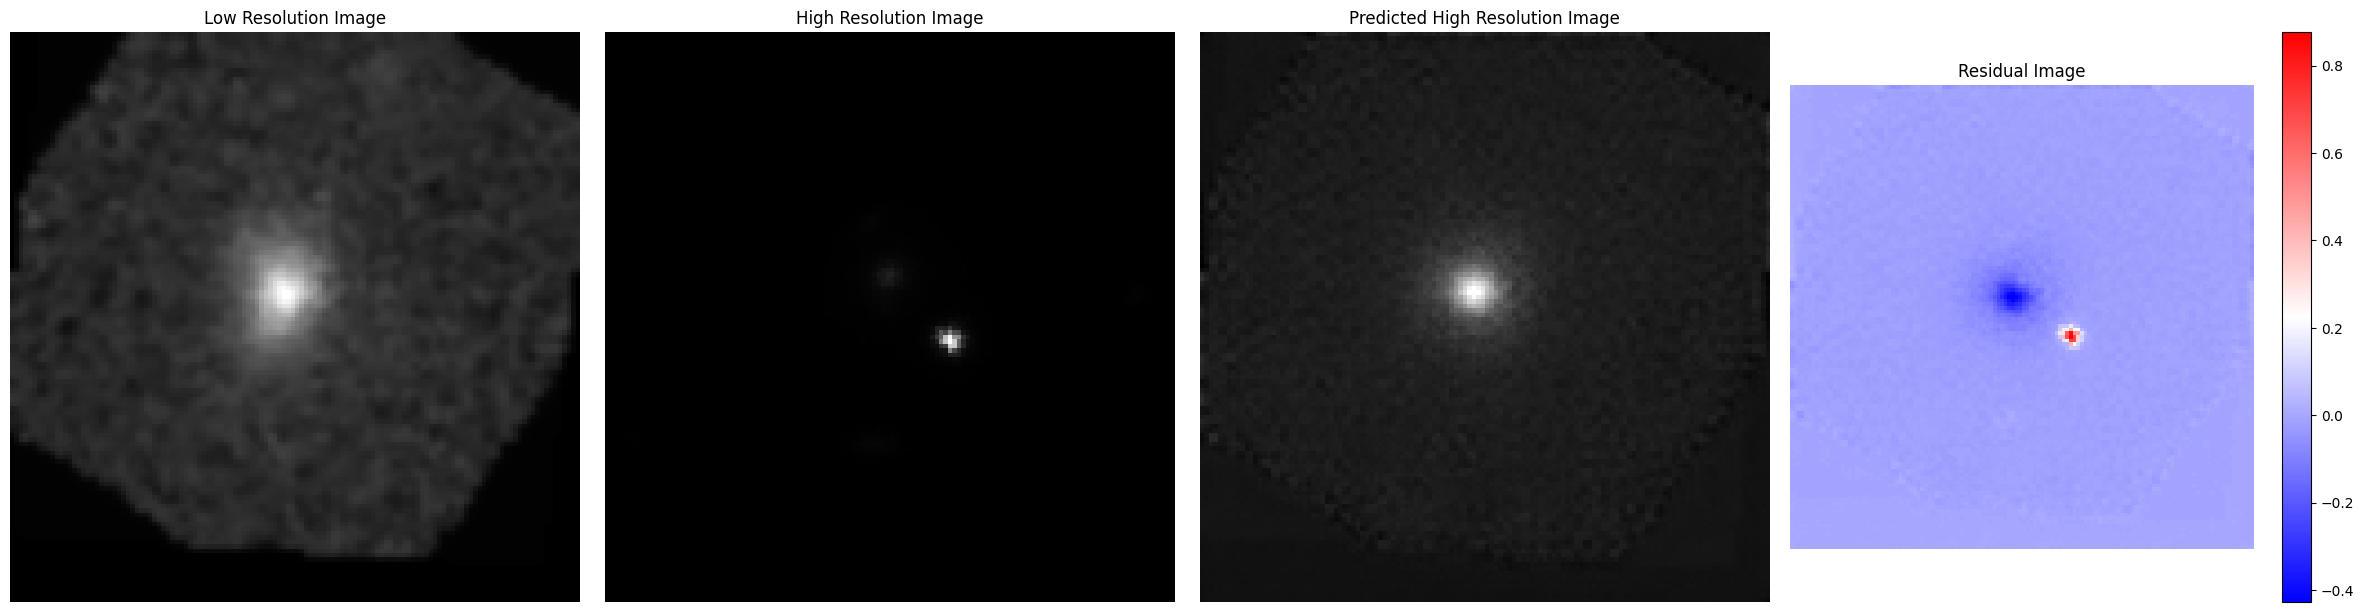

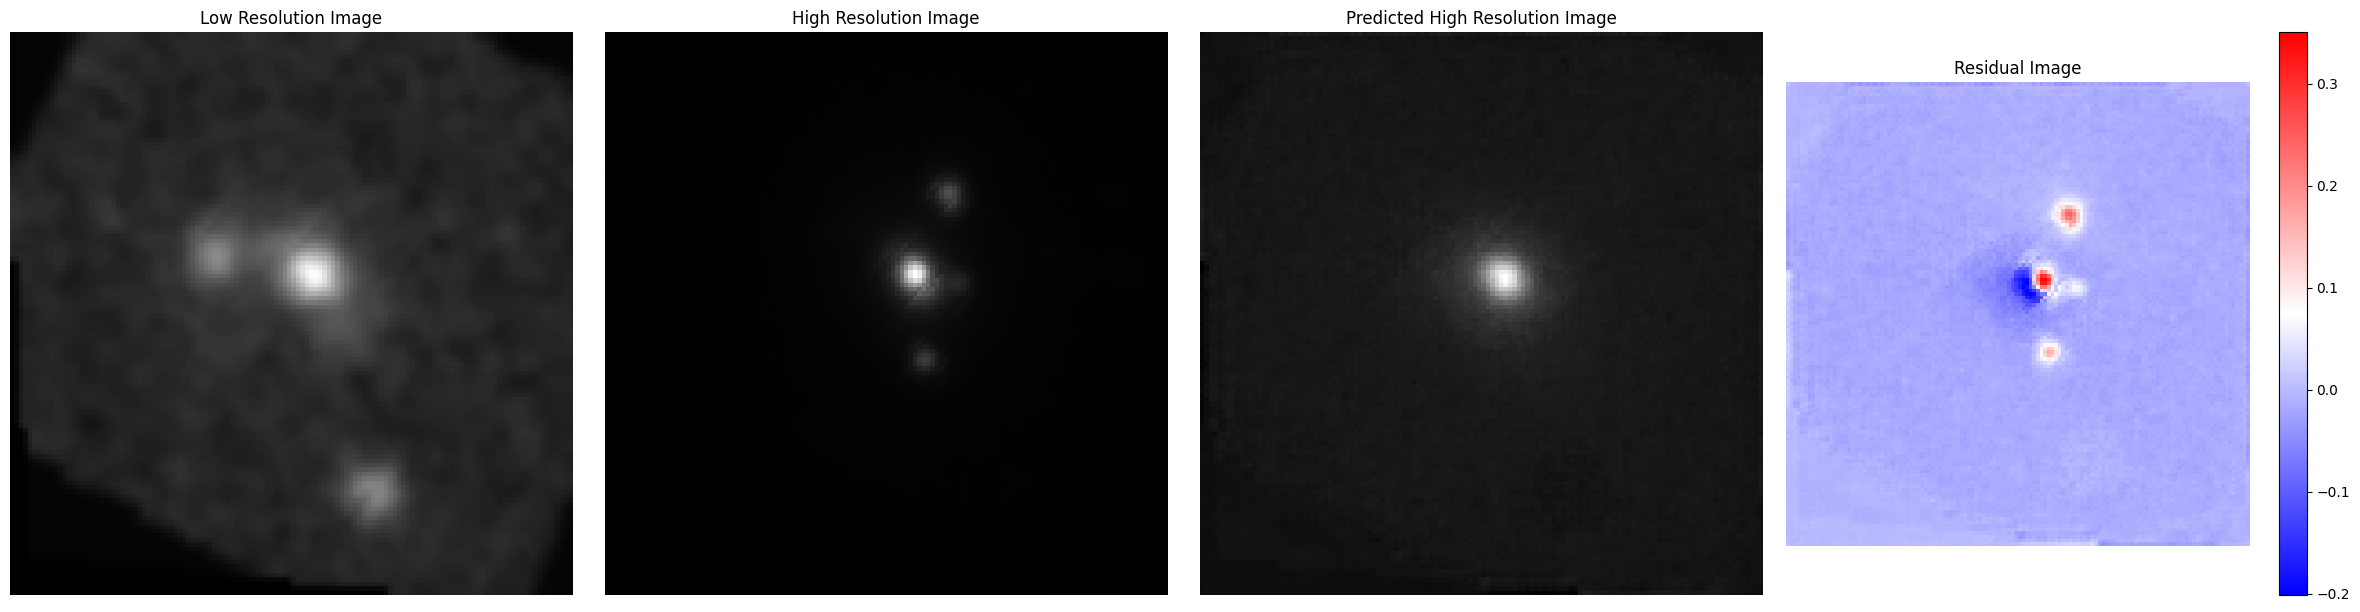

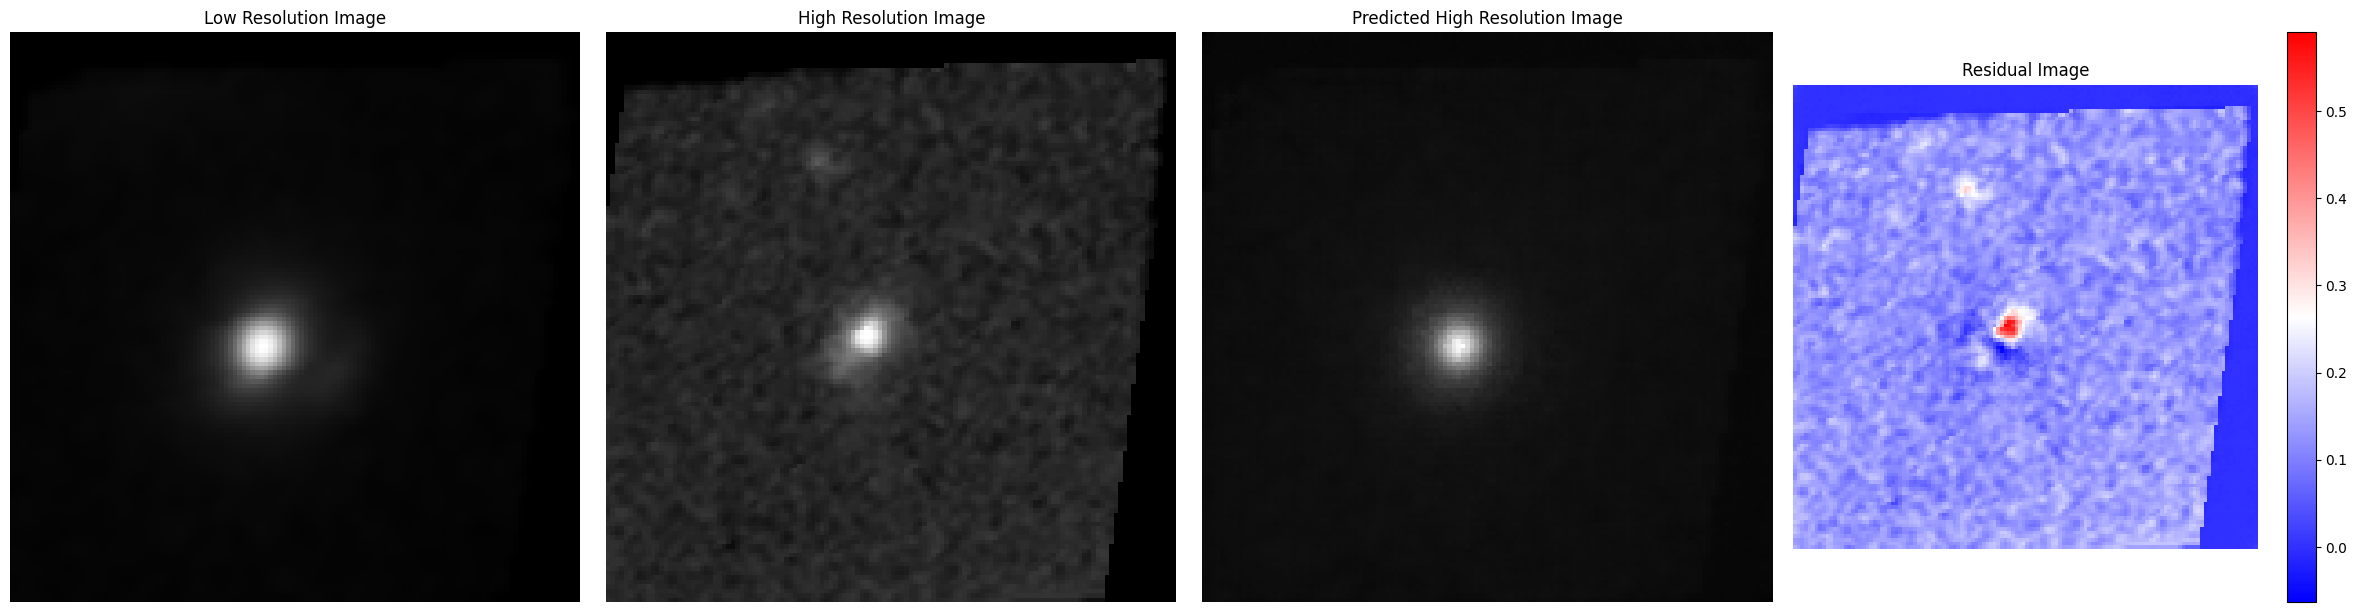

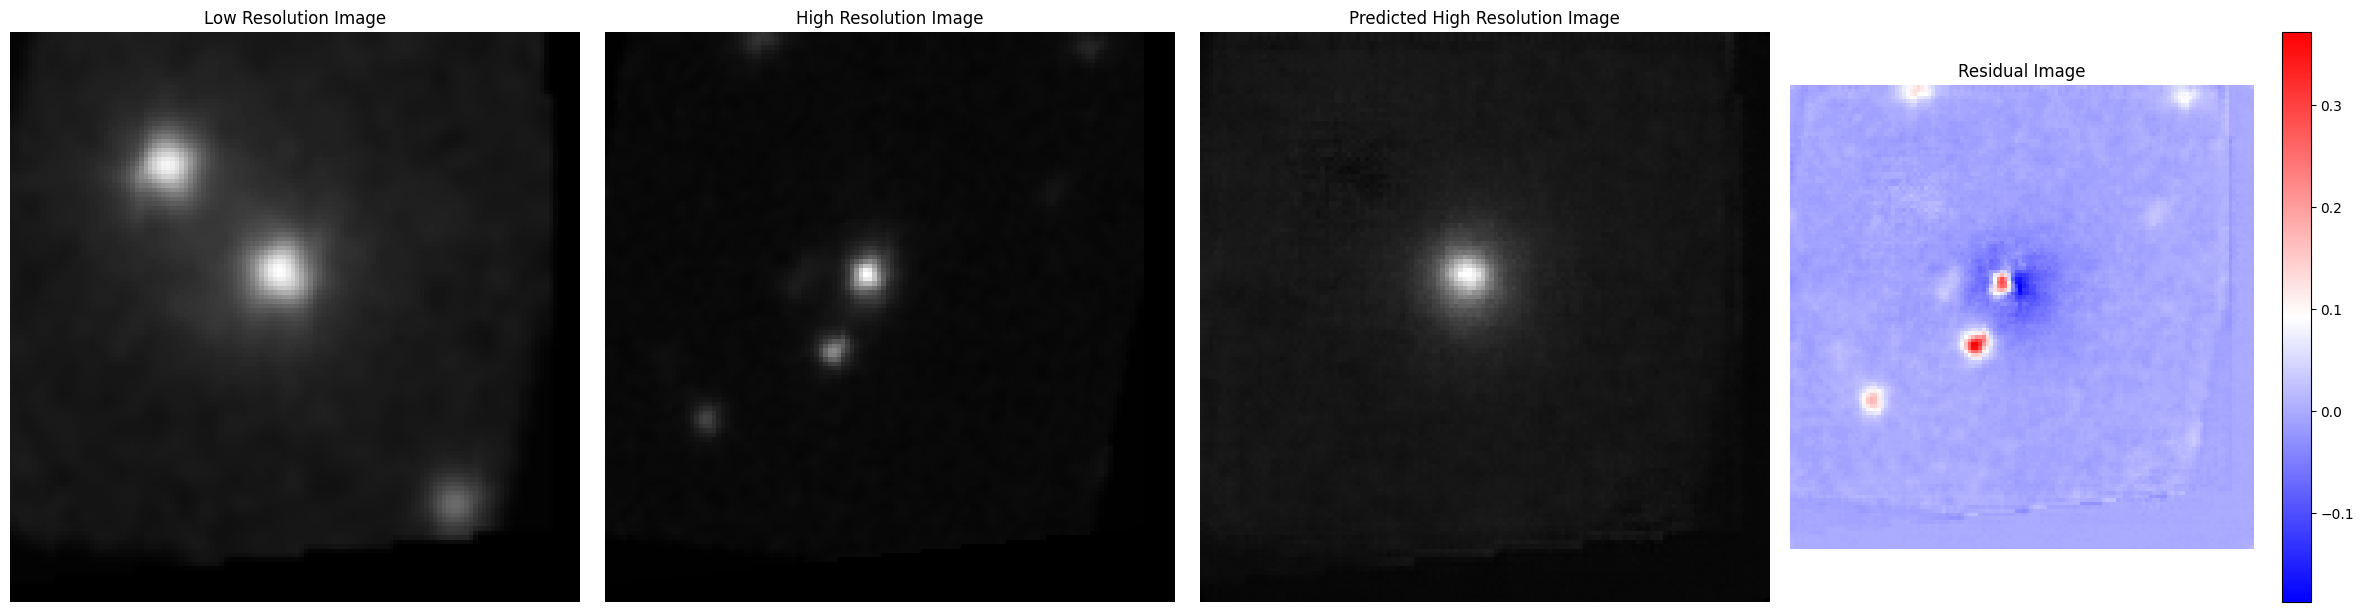

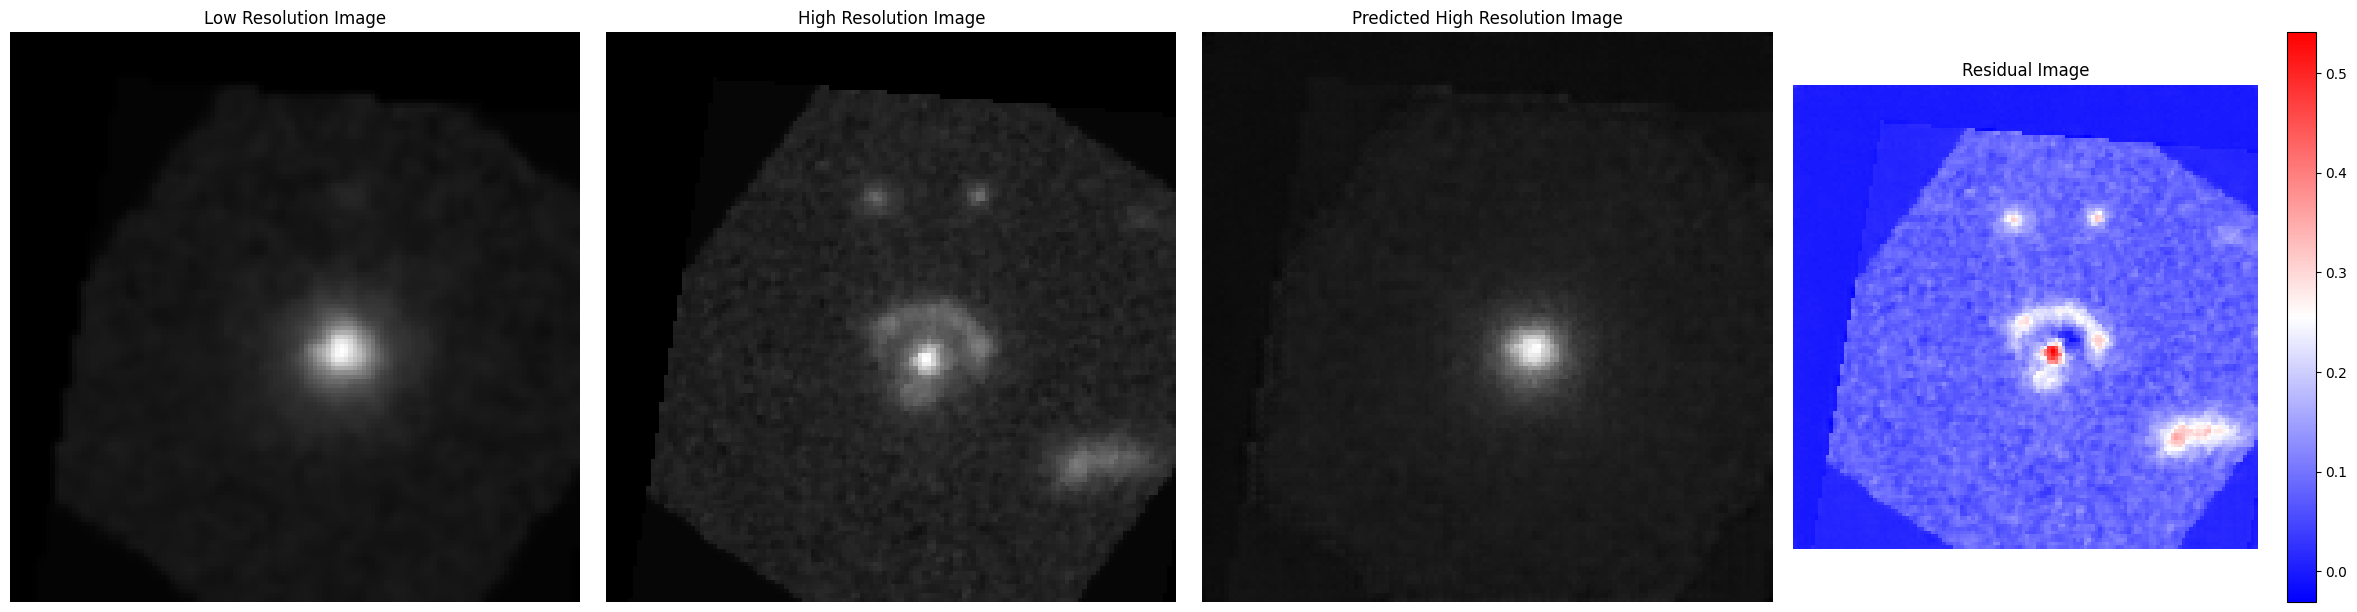

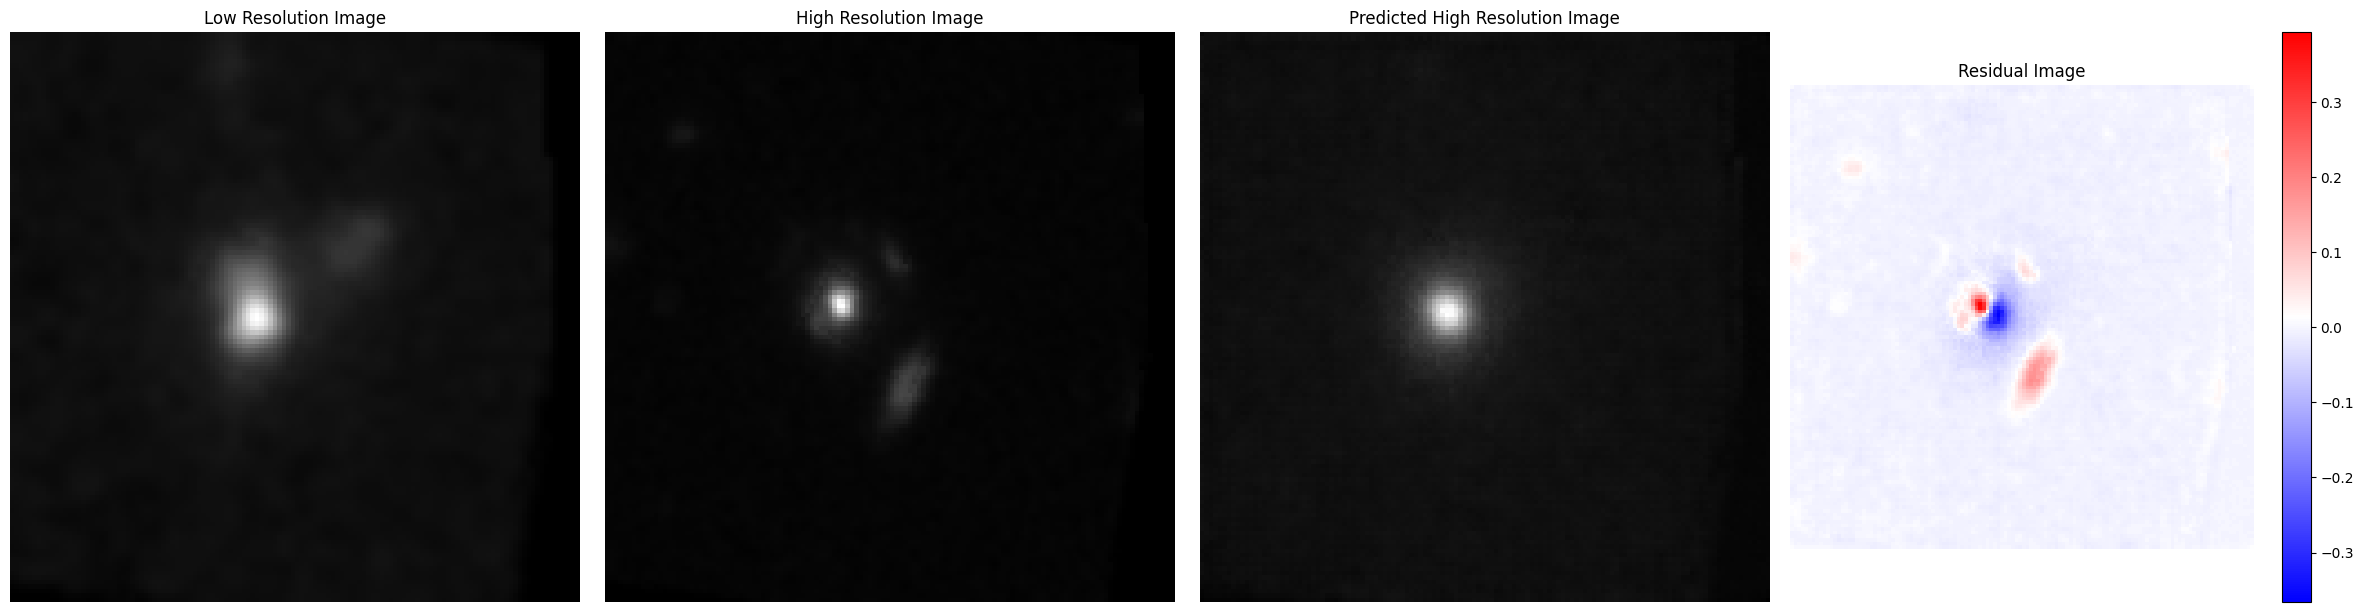

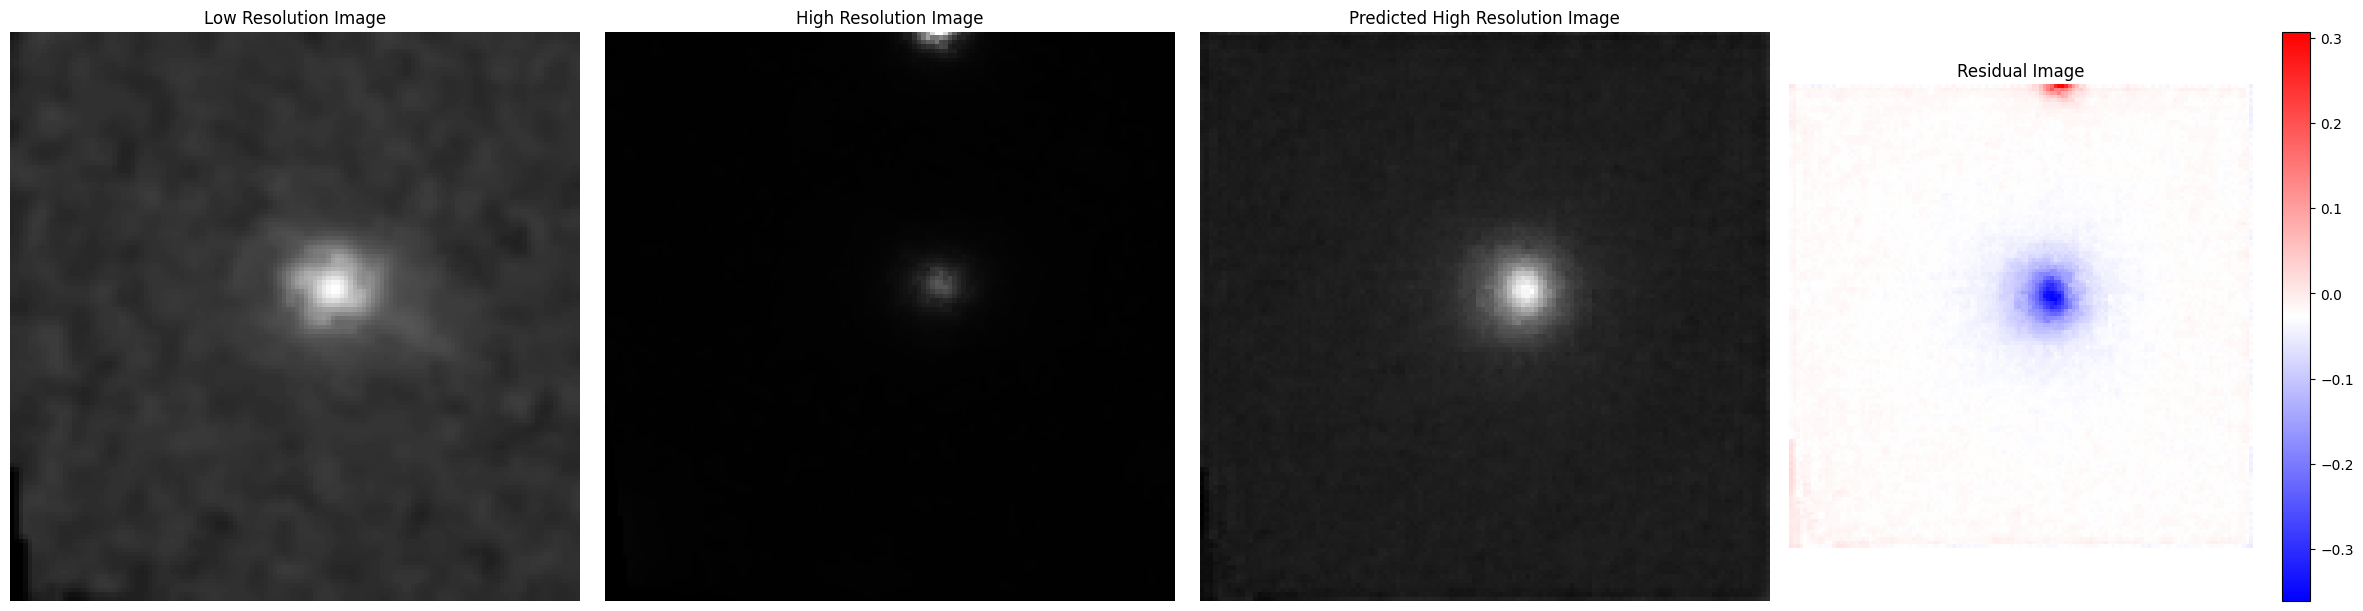

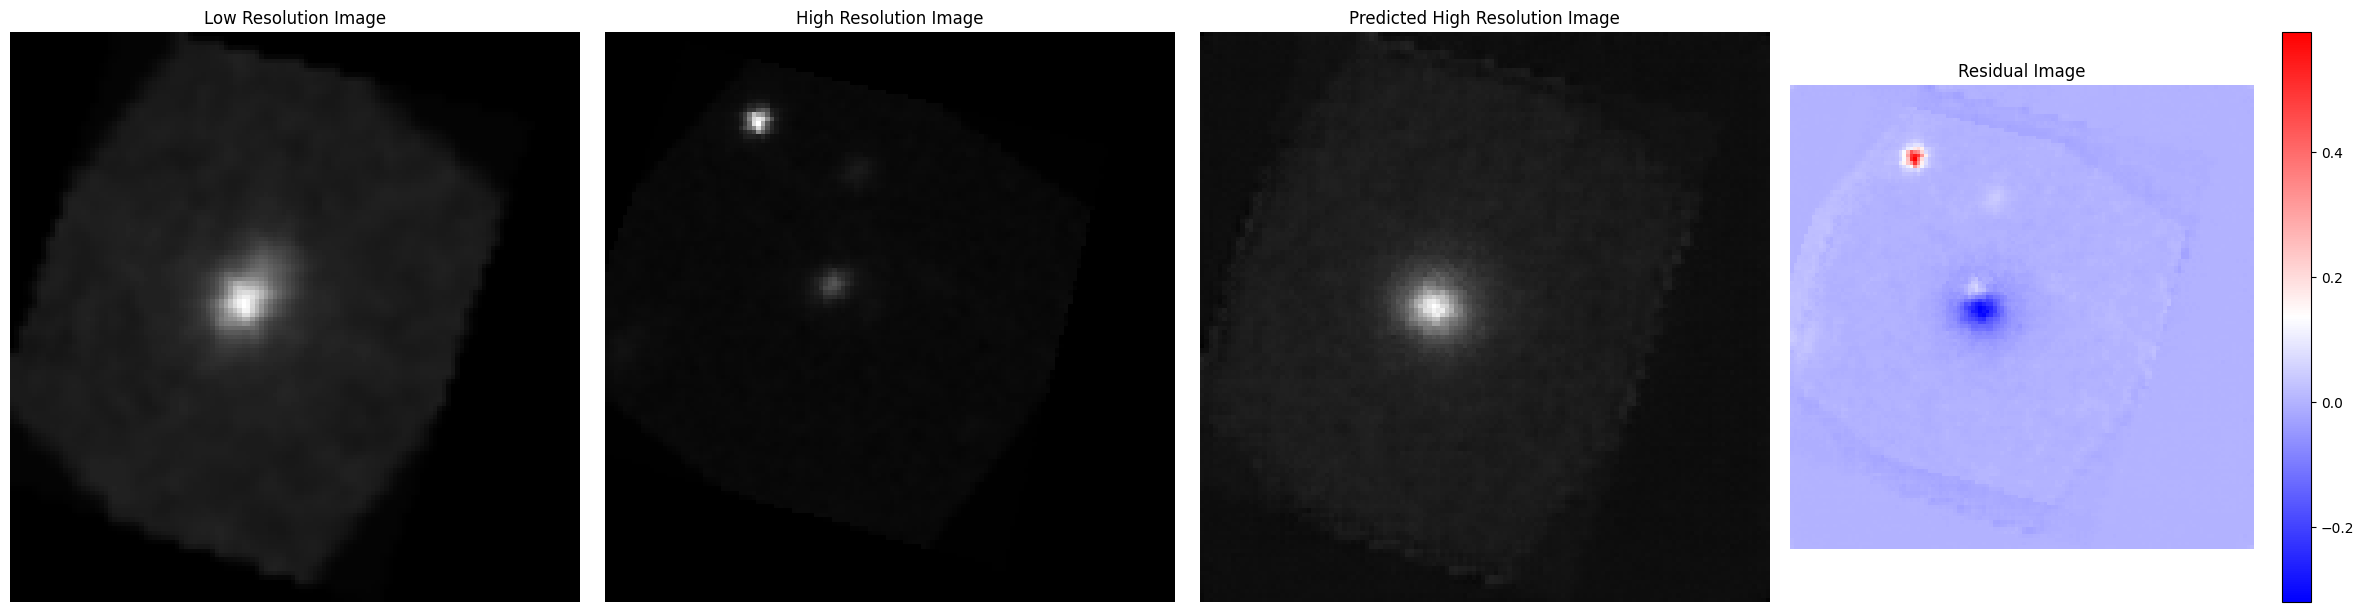

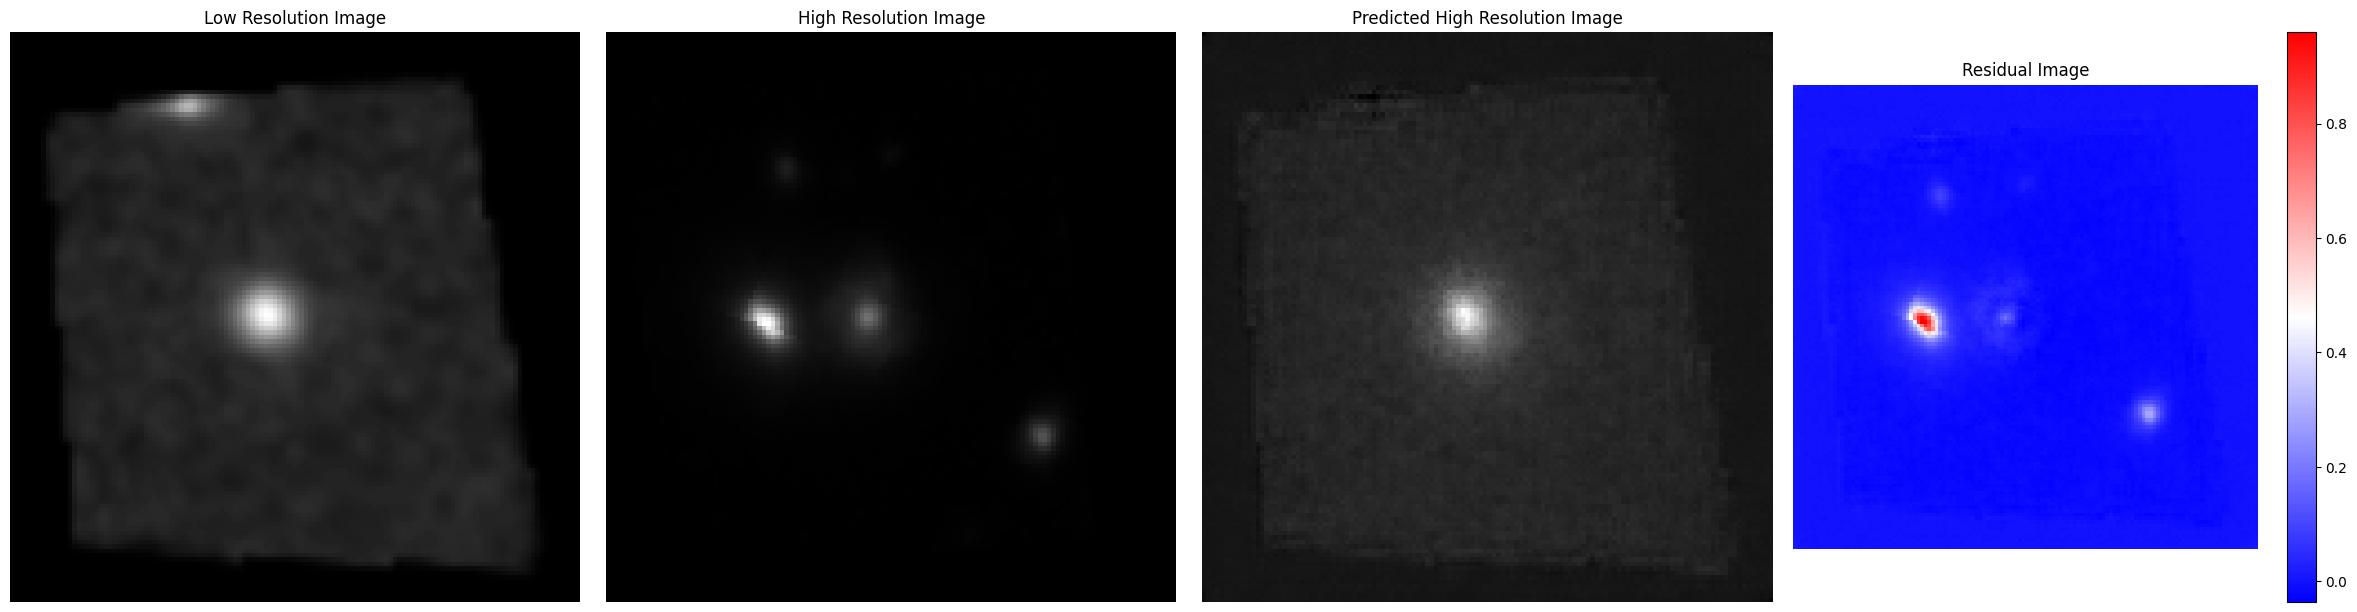

Evaluating:   0%|          | 0/1 [00:12<?, ?it/s]


KeyboardInterrupt: 

In [62]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

def evaluate_diffusion_model(model, test_dataloader, device, num_batches=5):
    model.eval()
    
    with torch.no_grad():
        for i, (lr_batch, hr_batch) in enumerate(tqdm(test_dataloader, desc="Evaluating")):
            if i >= num_batches:
                break
            
            lr_batch, hr_batch = lr_batch.to(device), hr_batch.to(device)=
            timesteps = torch.full((lr_batch.size(0),), 1000, device=device).long()
            random_residual = torch.randn_like(lr_batch)
            model_input = torch.cat([lr_batch, random_residual], dim=1)
            pred_hr_residual = model(model_input, timesteps)
            pred_hr_batch = lr_batch + pred_hr_residual
            
            lr_batch = lr_batch.cpu()
            hr_batch = hr_batch.cpu()
            pred_hr_batch = pred_hr_batch.cpu()
            pred_hr_residual = hr_batch-pred_hr_batch
            
            for j in range(lr_batch.size(0)):  
                lr = lr_batch[j].squeeze()
                hr = hr_batch[j].squeeze()
                pred_hr = pred_hr_batch[j].squeeze()
                residual = pred_hr_residual[j].squeeze()
                
                fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6))
                
                im1 = ax1.imshow(lr, cmap='gray')
                ax1.set_title('Low Resolution Image')
                ax1.axis('off')             
                im2 = ax2.imshow(hr, cmap='gray')
                ax2.set_title('High Resolution Image')
                ax2.axis('off')
                im3 = ax3.imshow(pred_hr, cmap='gray')
                ax3.set_title('Predicted High Resolution Image')
                ax3.axis('off')
                im4 = ax4.imshow(residual, cmap='bwr')
                ax4.set_title('Residual Image')
                ax4.axis('off')
                fig.colorbar(im4, ax=ax4)
                
                plt.tight_layout()
                plt.show()

evaluate_diffusion_model(model, test_loader, device, num_batches=5)